# Skills Analysis Dashboard
## Singapore Job Market Skills Insights (Oct 2022 - May 2024)

This notebook analyzes 2,053 unique skills across ~1M job postings to uncover:
- Emerging and declining skills
- High-value premium skills
- Experience requirements patterns
- Cross-industry transferable skills
- Skill co-occurrence networks

## Setup & Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set figure defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Load data
df = pd.read_parquet('../data/cleaned-sgjobdata-withskills.parquet')

# Parse dates
df['posting_date'] = pd.to_datetime(df['posting_date'])
df['year_month'] = df['posting_date'].dt.to_period('M')
df['year_month_dt'] = df['posting_date'].dt.to_period('M').dt.to_timestamp()

# Parse categories (extract category name from JSON)
def extract_category(cat_json):
    try:
        return json.loads(cat_json)[0]['category']
    except:
        return None

df['category_name'] = df['categories'].apply(extract_category)

print(f"Dataset loaded: {len(df):,} records")
print(f"Unique jobs: {df['job_id'].nunique():,}")
print(f"Unique skills: {df['skill'].nunique():,}")
print(f"Unique categories: {df['category_name'].nunique():,}")
print(f"Date range: {df['posting_date'].min().date()} to {df['posting_date'].max().date()}")

df.info()

Dataset loaded: 6,263,478 records
Unique jobs: 154,490
Unique skills: 2,053
Unique categories: 43
Date range: 2022-10-06 to 2024-05-29
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6263478 entries, 0 to 6263477
Data columns (total 17 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   job_id                  string        
 1   title                   string        
 2   company                 string        
 3   min_exp                 Int64         
 4   positionlevels          string        
 5   posting_date            datetime64[ns]
 6   num_applications        Int64         
 7   num_views               Int64         
 8   num_vacancies           Int64         
 9   categories              string        
 10  average_salary          Float64       
 11  average_salary_cleaned  Float64       
 12  jobtitle_cleaned        string        
 13  skill                   string        
 14  year_month              period[M]     
 15 

## 1. Skill Popularity Overview

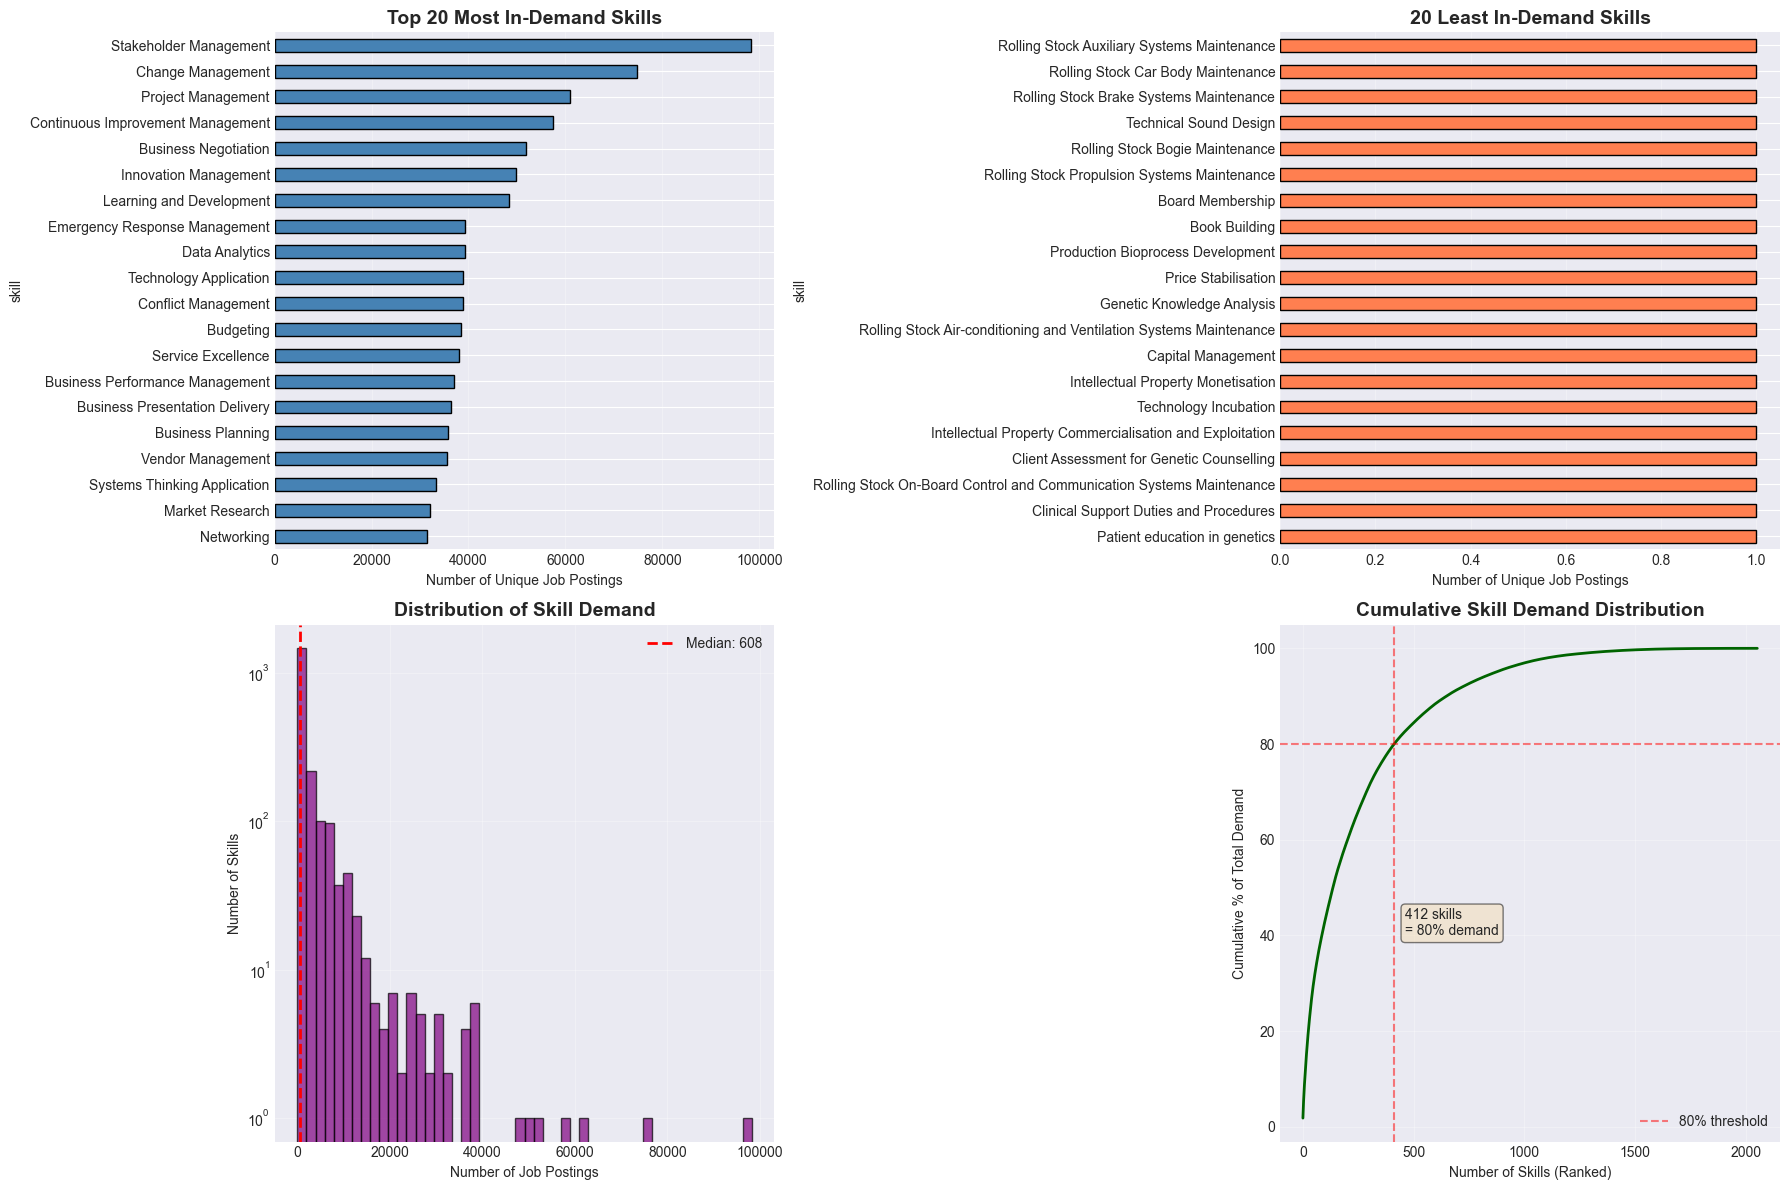


Top 10 Skills account for 10.3% of total demand
Top 100 Skills account for 42.9% of total demand
412 Skills account for 80% of total demand


In [3]:
# Calculate skill popularity (unique jobs per skill)
skill_counts = df.groupby('skill')['job_id'].nunique().sort_values(ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 20 popular skills
skill_counts.head(20).plot(kind='barh', ax=axes[0, 0], color='steelblue', edgecolor='black')
axes[0, 0].set_title('Top 20 Most In-Demand Skills', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Unique Job Postings')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Bottom 20 least popular skills
skill_counts.tail(20).plot(kind='barh', ax=axes[0, 1], color='coral', edgecolor='black')
axes[0, 1].set_title('20 Least In-Demand Skills', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Unique Job Postings')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Distribution histogram
axes[1, 0].hist(skill_counts.values, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Skill Demand', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Job Postings')
axes[1, 0].set_ylabel('Number of Skills')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axvline(skill_counts.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {skill_counts.median():.0f}')
axes[1, 0].legend()

# Cumulative distribution
sorted_skills = skill_counts.sort_values(ascending=False)
cumulative_pct = (sorted_skills.cumsum() / sorted_skills.sum() * 100)
axes[1, 1].plot(range(len(cumulative_pct)), cumulative_pct.values, linewidth=2, color='darkgreen')
axes[1, 1].set_title('Cumulative Skill Demand Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Skills (Ranked)')
axes[1, 1].set_ylabel('Cumulative % of Total Demand')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
# Find how many skills account for 80% of demand
skills_for_80pct = (cumulative_pct <= 80).sum()
axes[1, 1].axvline(skills_for_80pct, color='red', linestyle='--', alpha=0.5)
axes[1, 1].text(skills_for_80pct + 50, 40, f'{skills_for_80pct} skills\n= 80% demand', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\nTop 10 Skills account for {cumulative_pct.iloc[9]:.1f}% of total demand")
print(f"Top 100 Skills account for {cumulative_pct.iloc[99]:.1f}% of total demand")
print(f"{skills_for_80pct} Skills account for 80% of total demand")

## 2. Emerging & Declining Skills (Temporal Analysis)

In [4]:
# Calculate monthly trends for each skill
skill_timeline = df.groupby(['year_month', 'skill'])['job_id'].nunique().reset_index()
skill_timeline.columns = ['year_month', 'skill', 'unique_jobs']
skill_timeline['year_month_dt'] = skill_timeline['year_month'].dt.to_timestamp()

# Calculate growth rate: compare recent 3 months vs previous 3 months
recent_period = skill_timeline['year_month'].max()
prev_period_start = recent_period - 5  # 6 months ago (0-indexed)
prev_period_end = recent_period - 3    # 3 months ago

recent_3m = skill_timeline[skill_timeline['year_month'] > prev_period_end]
prev_3m = skill_timeline[(skill_timeline['year_month'] > prev_period_start) & 
                         (skill_timeline['year_month'] <= prev_period_end)]

recent_counts = recent_3m.groupby('skill')['unique_jobs'].sum()
prev_counts = prev_3m.groupby('skill')['unique_jobs'].sum()

# Calculate growth rate (filter skills that appeared in both periods)
common_skills = recent_counts.index.intersection(prev_counts.index)
growth_rate = ((recent_counts[common_skills] - prev_counts[common_skills]) / prev_counts[common_skills] * 100)
growth_rate = growth_rate.sort_values(ascending=False)

# Filter for skills with decent volume (at least 20 jobs in previous period)
growth_rate_filtered = growth_rate[prev_counts[growth_rate.index] >= 20]

print(f"Analyzing growth from {prev_period_start} to {prev_period_end} vs {prev_period_end} to {recent_period}")
print(f"Skills analyzed: {len(growth_rate_filtered)}")

Analyzing growth from 2023-12 to 2024-02 vs 2024-02 to 2024-05
Skills analyzed: 1454


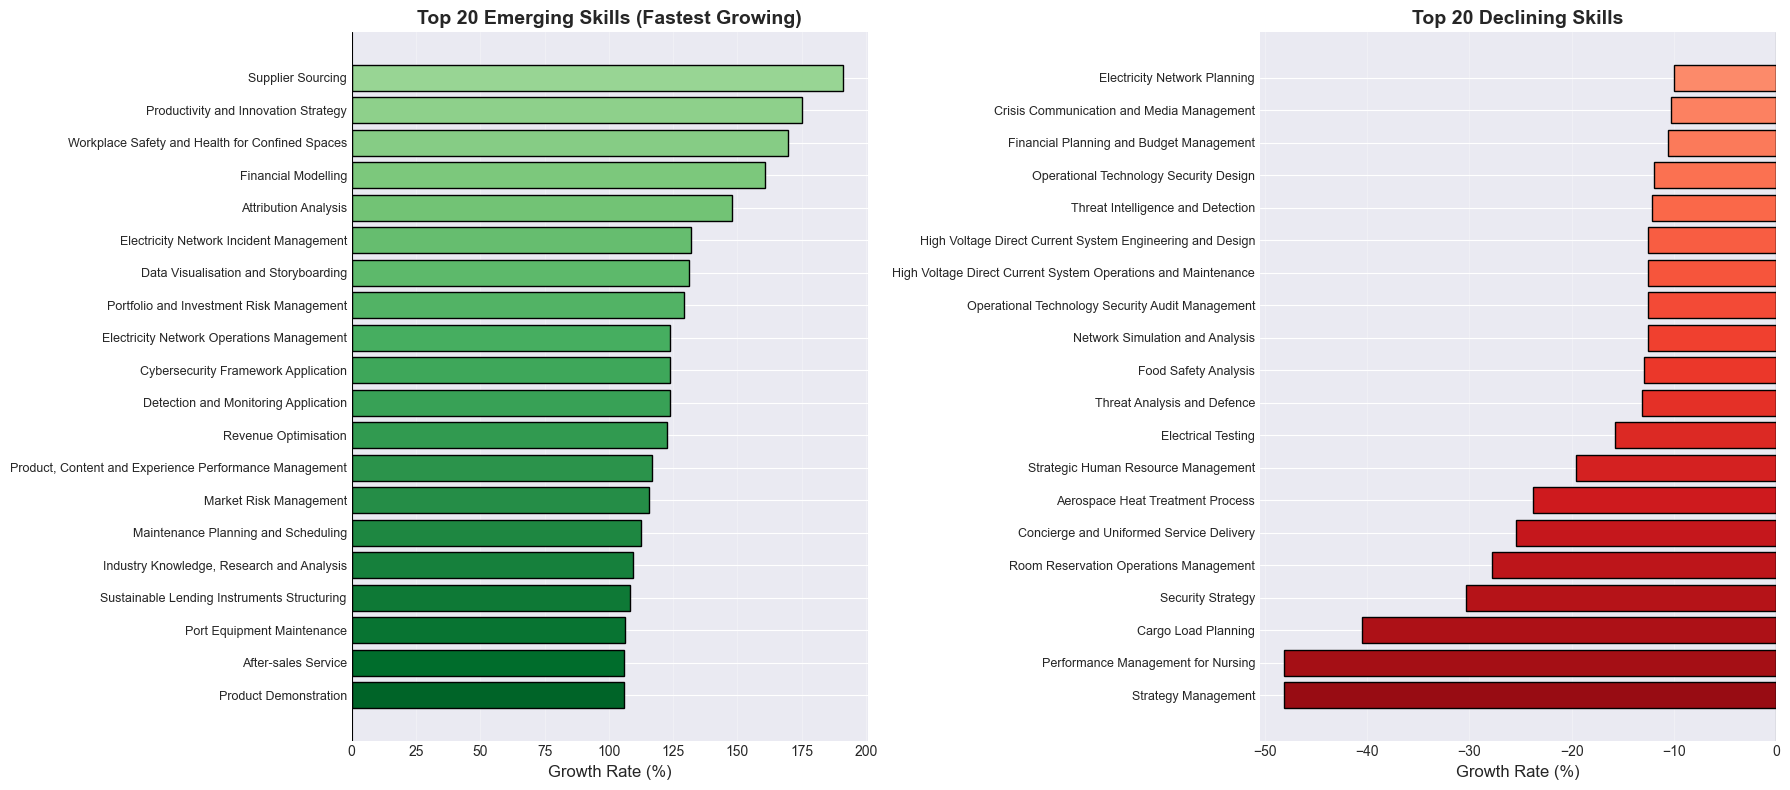

In [5]:
# Visualization: Emerging & Declining Skills
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 Emerging skills
emerging = growth_rate_filtered.head(20)
colors_emerging = plt.cm.Greens(np.linspace(0.4, 0.9, len(emerging)))
ax1.barh(range(len(emerging)), emerging.values, color=colors_emerging, edgecolor='black')
ax1.set_yticks(range(len(emerging)))
ax1.set_yticklabels(emerging.index, fontsize=9)
ax1.set_title('Top 20 Emerging Skills (Fastest Growing)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Growth Rate (%)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(0, color='black', linewidth=0.8)

# Top 20 Declining skills
declining = growth_rate_filtered.tail(20)
colors_declining = plt.cm.Reds(np.linspace(0.4, 0.9, len(declining)))
ax2.barh(range(len(declining)), declining.values, color=colors_declining, edgecolor='black')
ax2.set_yticks(range(len(declining)))
ax2.set_yticklabels(declining.index, fontsize=9)
ax2.set_title('Top 20 Declining Skills', fontsize=14, fontweight='bold')
ax2.set_xlabel('Growth Rate (%)', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
ax2.axvline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

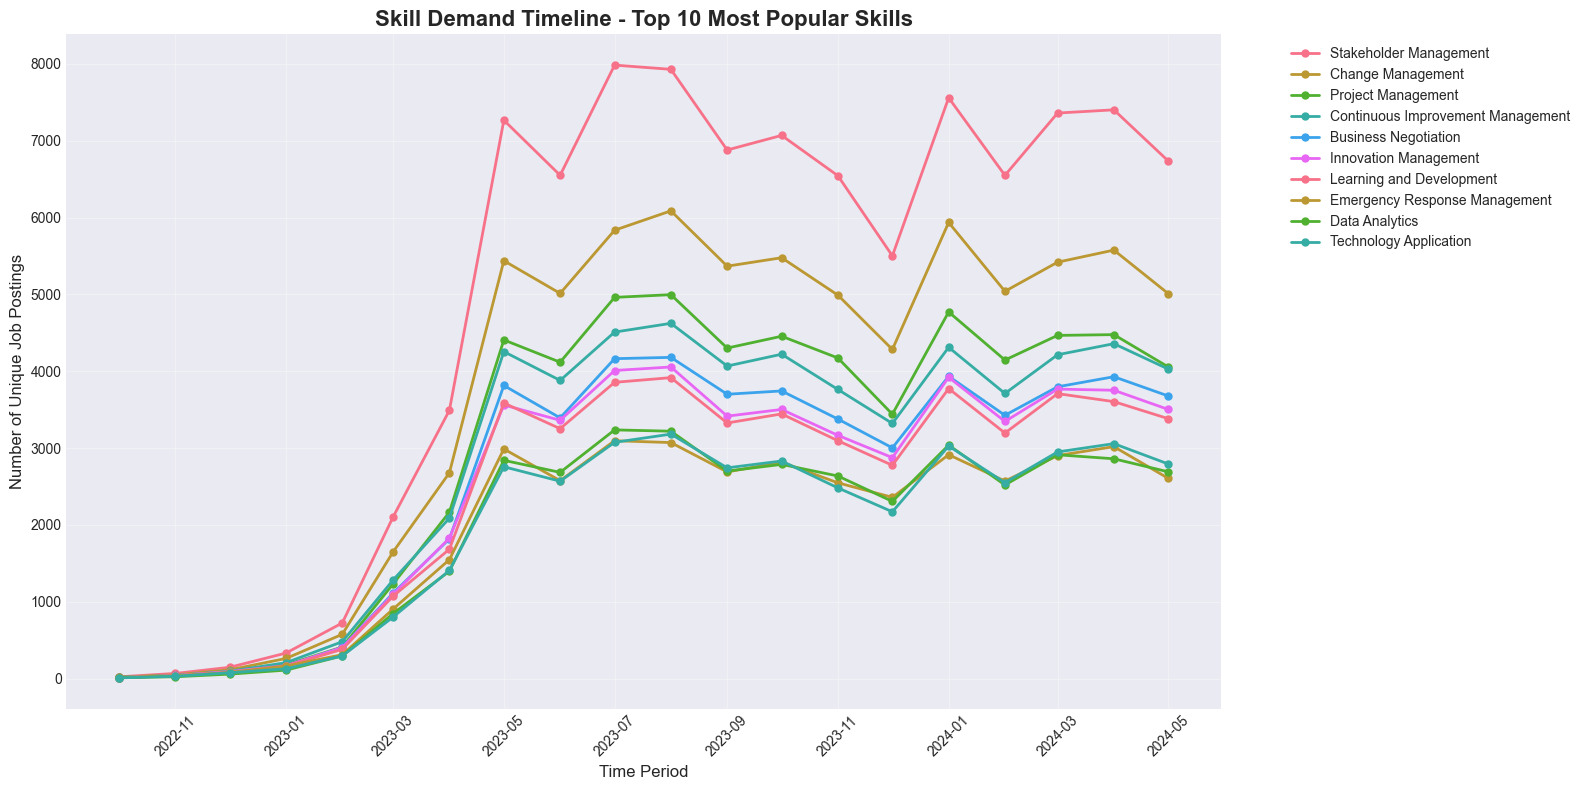

In [6]:
# Timeline visualization for top 10 skills
top_10_skills = skill_counts.head(10).index
timeline_top10 = skill_timeline[skill_timeline['skill'].isin(top_10_skills)]

plt.figure(figsize=(16, 8))
for skill in top_10_skills:
    data = timeline_top10[timeline_top10['skill'] == skill]
    plt.plot(data['year_month_dt'], data['unique_jobs'], marker='o', label=skill, linewidth=2, markersize=5)

plt.title('Skill Demand Timeline - Top 10 Most Popular Skills', fontsize=16, fontweight='bold')
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Number of Unique Job Postings', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Skills vs Minimum Experience Level

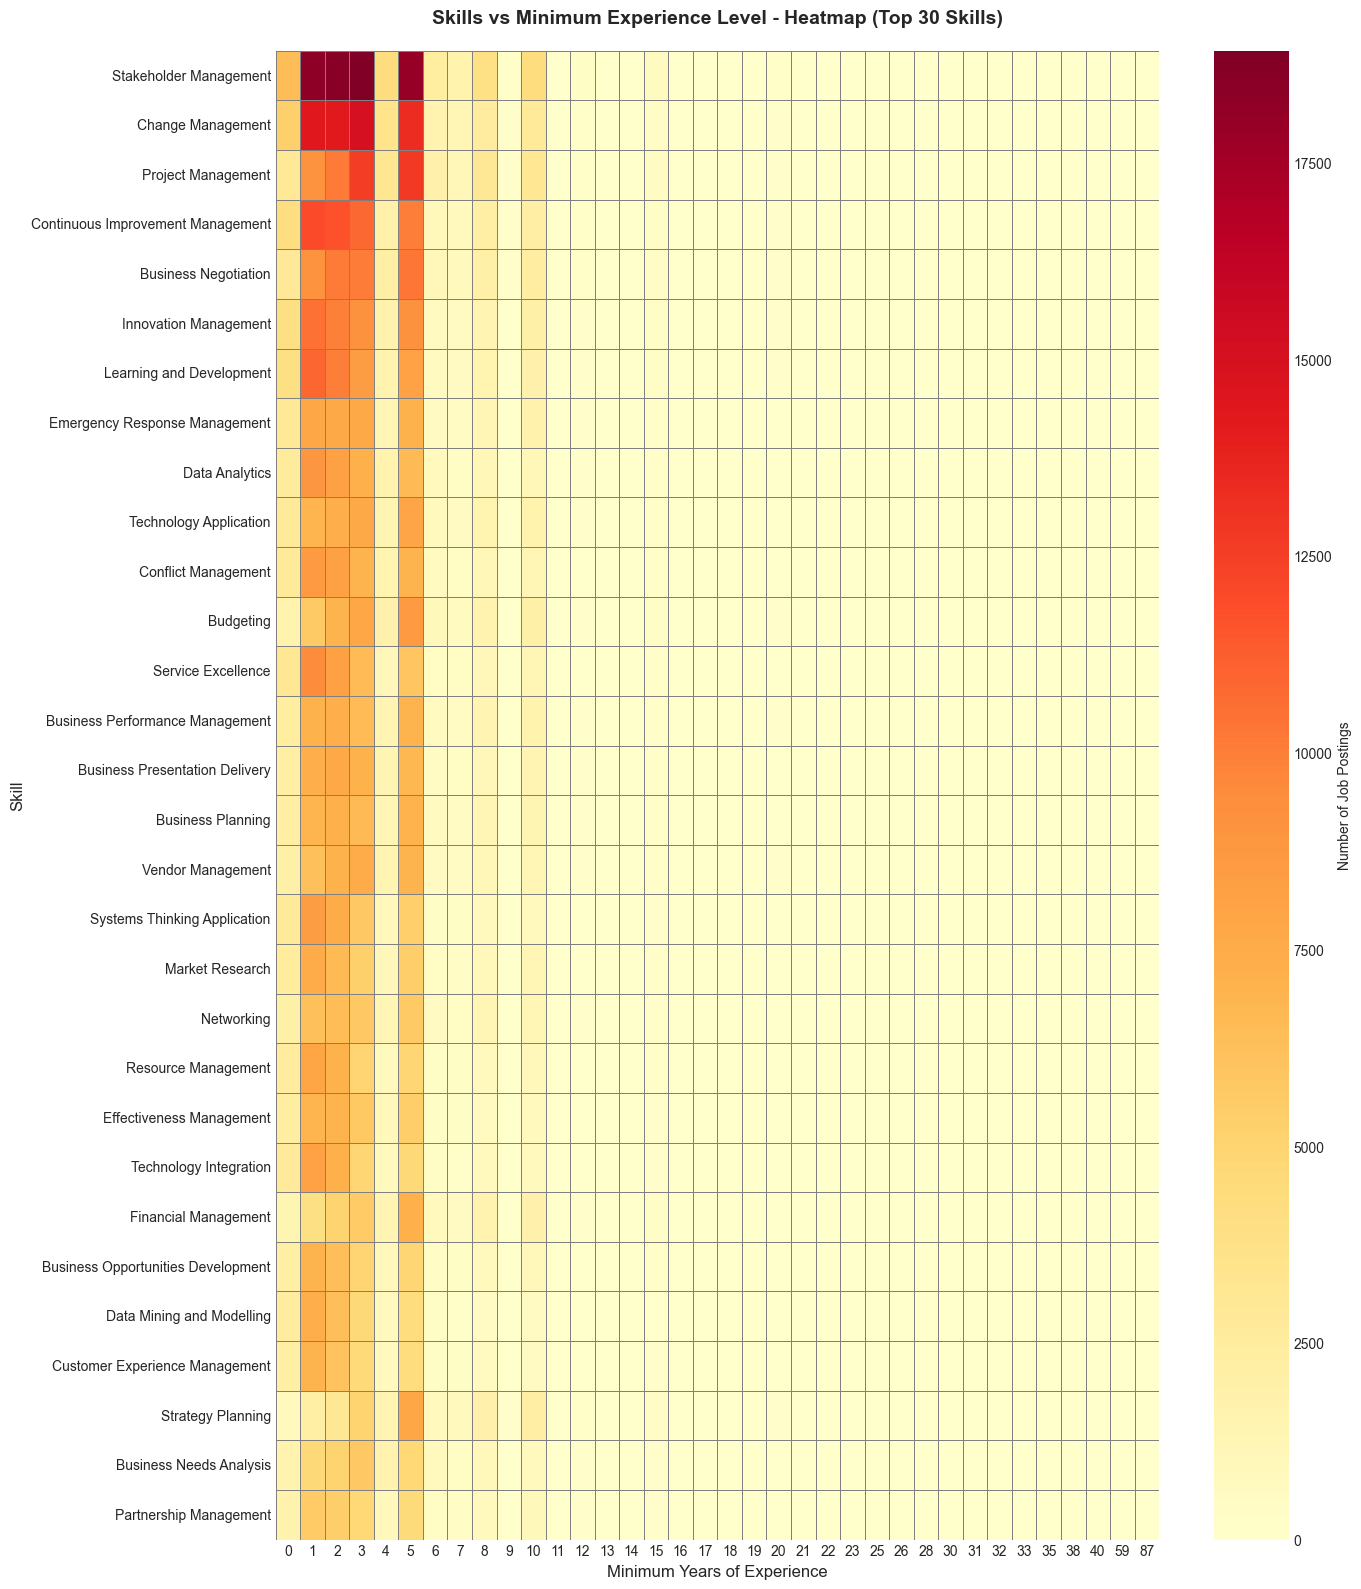

In [7]:
# Prepare data: skill vs experience
skills_exp = df.groupby(['skill', 'min_exp'])['job_id'].nunique().reset_index()
skills_exp_pivot = skills_exp.pivot_table(index='skill', columns='min_exp', values='job_id', fill_value=0)

# Get top 30 skills for visualization
top_30_skills = skill_counts.head(30).index
skills_exp_top = skills_exp_pivot.loc[top_30_skills]

# Heatmap
plt.figure(figsize=(14, 16))
sns.heatmap(skills_exp_top, cmap='YlOrRd', annot=False, fmt='d', 
            cbar_kws={'label': 'Number of Job Postings'},
            linewidths=0.5, linecolor='gray')
plt.title('Skills vs Minimum Experience Level - Heatmap (Top 30 Skills)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Minimum Years of Experience', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.tight_layout()
plt.show()

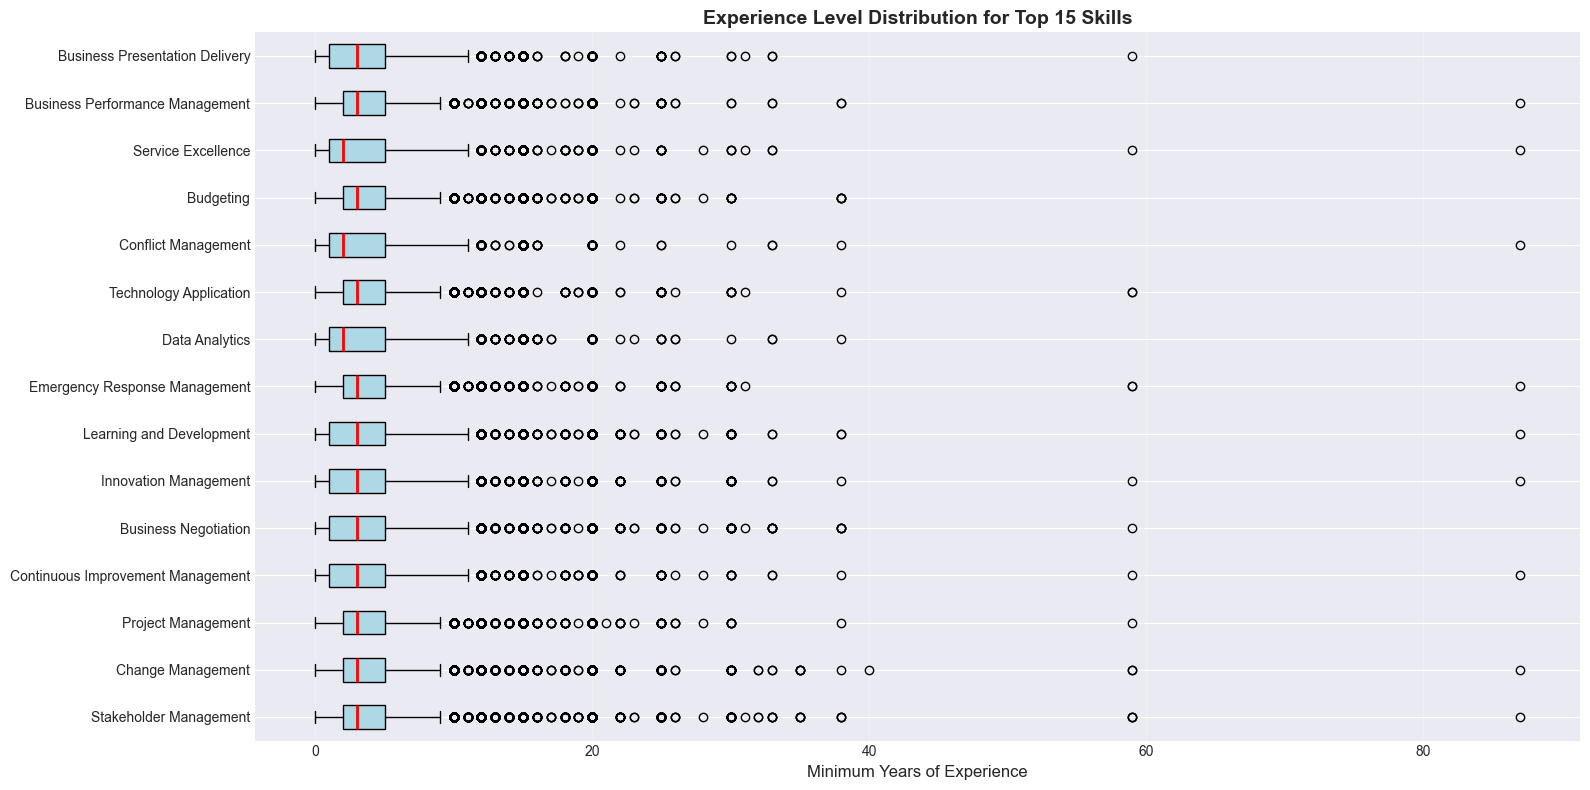

In [8]:
# Box plot: Experience distribution for top 15 skills
top_15_skills = skill_counts.head(15).index
data_to_plot = [df[df['skill'] == skill]['min_exp'].dropna().values for skill in top_15_skills]

fig, ax = plt.subplots(figsize=(16, 8))
bp = ax.boxplot(data_to_plot, labels=top_15_skills, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue', edgecolor='black'),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'))

ax.set_xlabel('Minimum Years of Experience', fontsize=12)
ax.set_title('Experience Level Distribution for Top 15 Skills', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

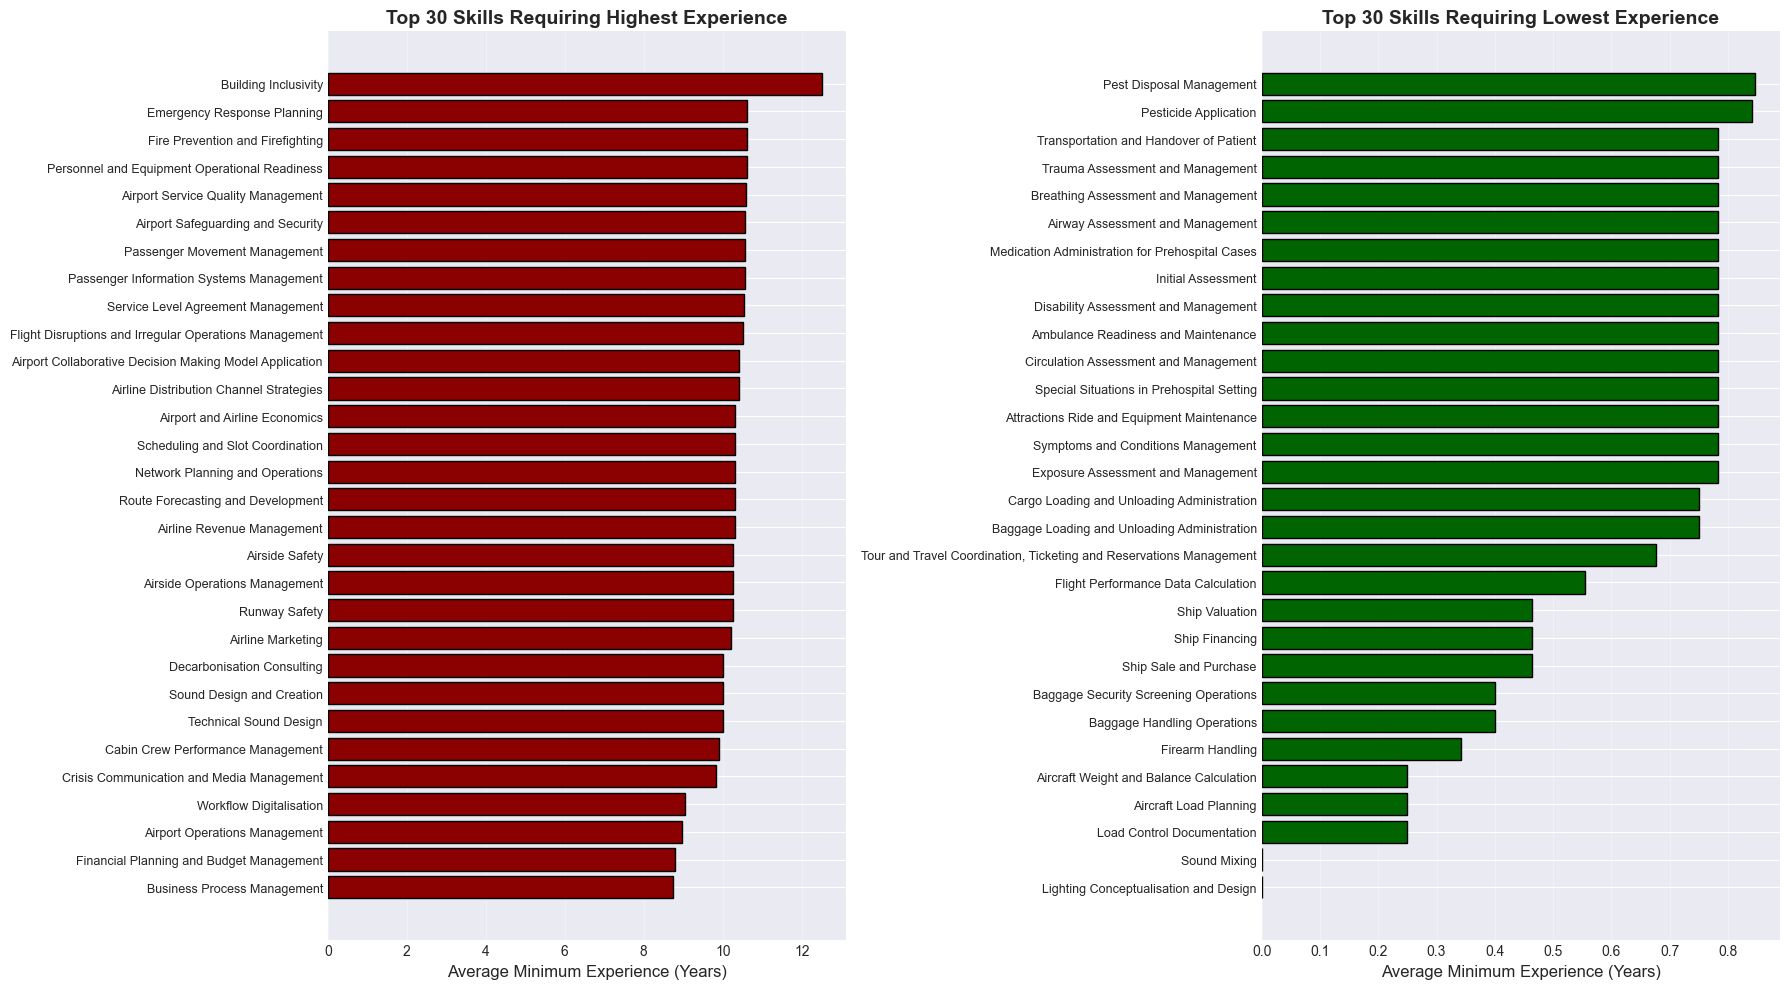

In [9]:
# Average experience by skill (Top 30)
avg_exp_by_skill = df.groupby('skill')['min_exp'].mean().sort_values(ascending=False)
top_30_high_exp = avg_exp_by_skill.head(30)
top_30_low_exp = avg_exp_by_skill.tail(30)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

# Skills requiring highest experience
ax1.barh(range(len(top_30_high_exp)), top_30_high_exp.values, color='darkred', edgecolor='black')
ax1.set_yticks(range(len(top_30_high_exp)))
ax1.set_yticklabels(top_30_high_exp.index, fontsize=9)
ax1.set_title('Top 30 Skills Requiring Highest Experience', fontsize=14, fontweight='bold')
ax1.set_xlabel('Average Minimum Experience (Years)', fontsize=12)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Skills requiring lowest experience
ax2.barh(range(len(top_30_low_exp)), top_30_low_exp.values, color='darkgreen', edgecolor='black')
ax2.set_yticks(range(len(top_30_low_exp)))
ax2.set_yticklabels(top_30_low_exp.index, fontsize=9)
ax2.set_title('Top 30 Skills Requiring Lowest Experience', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Minimum Experience (Years)', fontsize=12)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4. High Premium Skills (Salary Analysis)

In [10]:
# Calculate average salary and demand by skill
skill_salary = df.groupby('skill').agg({
    'average_salary_cleaned': 'mean',
    'job_id': 'nunique',
    'min_exp': 'mean'
}).reset_index()
skill_salary.columns = ['skill', 'avg_salary', 'job_count', 'avg_exp']
skill_salary = skill_salary.dropna(subset=['avg_salary'])

# Filter for skills with decent sample size (at least 100 unique job postings)
skill_salary_filtered = skill_salary[skill_salary['job_count'] >= 100].copy()

print(f"Skills with salary data and >=100 job postings: {len(skill_salary_filtered)}")
print(f"Average salary range: ${skill_salary_filtered['avg_salary'].min():.0f} - ${skill_salary_filtered['avg_salary'].max():.0f}")

Skills with salary data and >=100 job postings: 1505
Average salary range: $2045 - $15138


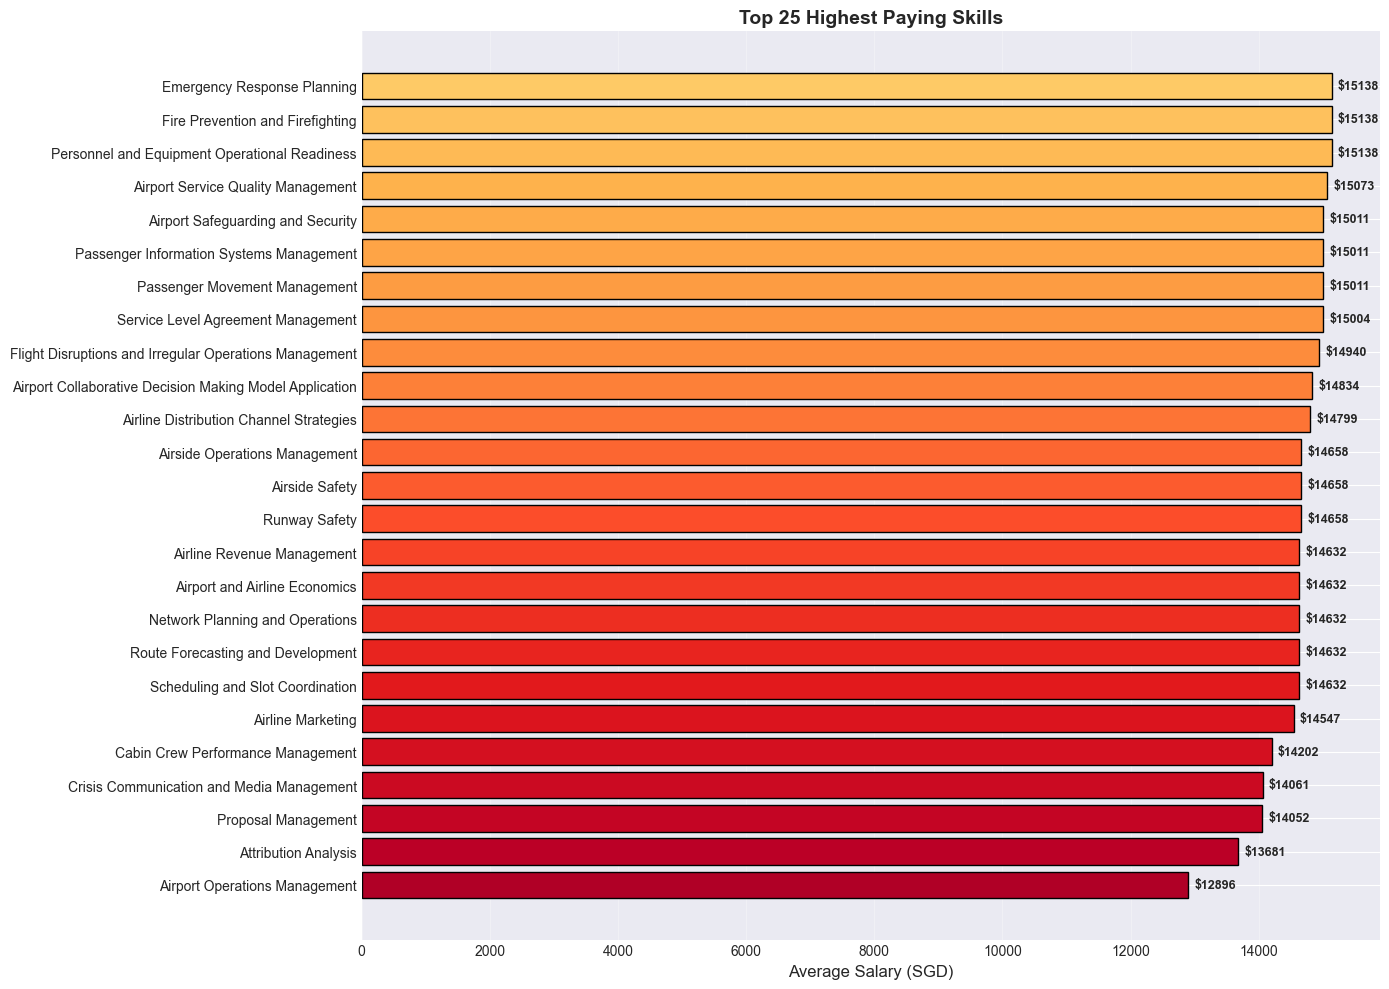

In [11]:
# Top premium skills
top_premium = skill_salary_filtered.nlargest(25, 'avg_salary')

plt.figure(figsize=(14, 10))
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(top_premium)))
bars = plt.barh(range(len(top_premium)), top_premium['avg_salary'], color=colors, edgecolor='black')
plt.yticks(range(len(top_premium)), top_premium['skill'], fontsize=10)
plt.xlabel('Average Salary (SGD)', fontsize=12)
plt.title('Top 25 Highest Paying Skills', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top_premium.iterrows()):
    plt.text(row['avg_salary'] + 100, i, f"${row['avg_salary']:.0f}", 
             va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

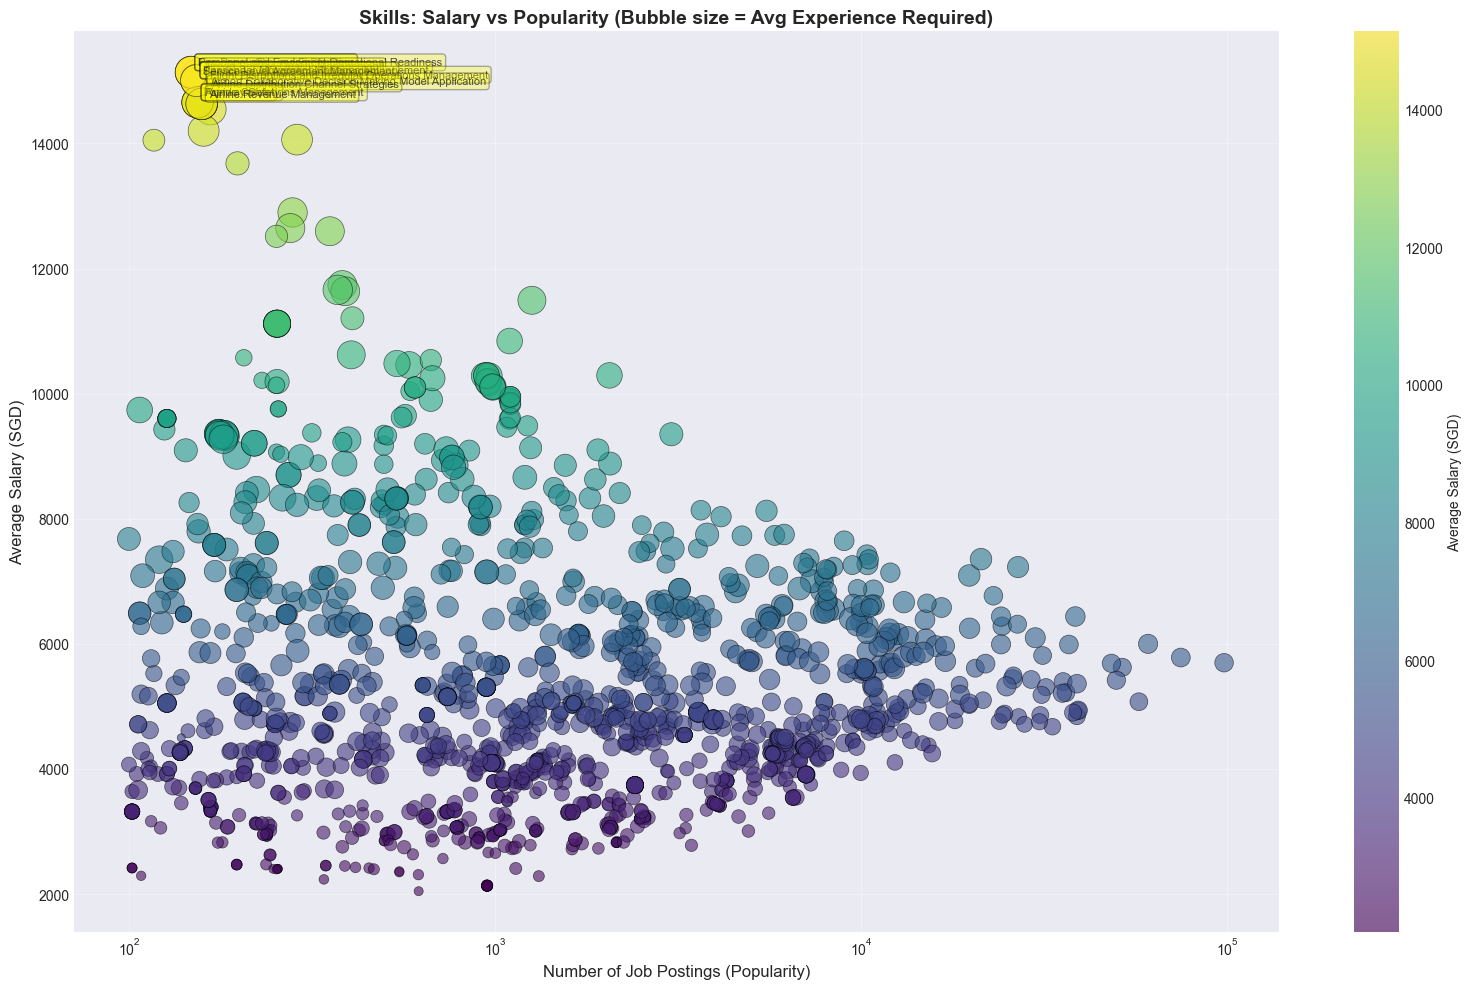

In [12]:
# Bubble chart: Salary vs Popularity vs Experience
plt.figure(figsize=(16, 10))

scatter = plt.scatter(skill_salary_filtered['job_count'], 
                     skill_salary_filtered['avg_salary'],
                     s=skill_salary_filtered['avg_exp']*50,  # Size by avg experience
                     alpha=0.6,
                     c=skill_salary_filtered['avg_salary'],
                     cmap='viridis',
                     edgecolors='black',
                     linewidth=0.5)

# Annotate top paying skills
top_salary_skills = skill_salary_filtered.nlargest(15, 'avg_salary')
for idx, row in top_salary_skills.iterrows():
    plt.annotate(row['skill'], 
                xy=(row['job_count'], row['avg_salary']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=8, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.xlabel('Number of Job Postings (Popularity)', fontsize=12)
plt.ylabel('Average Salary (SGD)', fontsize=12)
plt.title('Skills: Salary vs Popularity (Bubble size = Avg Experience Required)', fontsize=14, fontweight='bold')
plt.xscale('log')
plt.grid(alpha=0.3)
cbar = plt.colorbar(scatter, label='Average Salary (SGD)')
plt.tight_layout()
plt.show()

High-Value Skills (Above median salary: $4809, Below median experience: 3.1 years)


<Figure size 1400x1000 with 0 Axes>

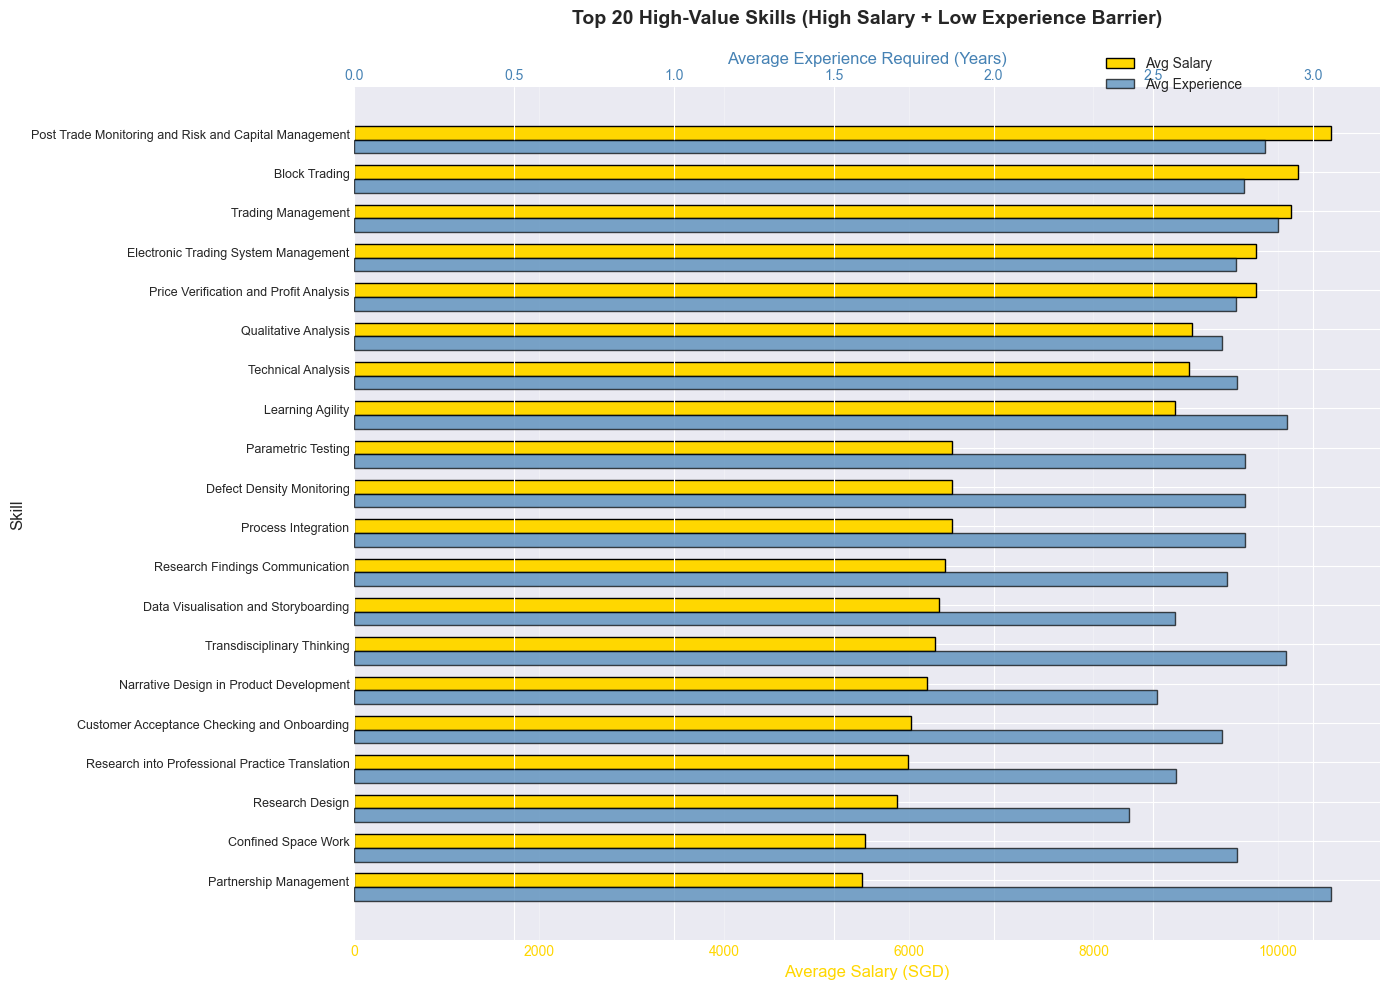

In [13]:
# High value skills: High salary but low experience requirement
# Define "high value" as skills with above-median salary but below-median experience
median_salary = skill_salary_filtered['avg_salary'].median()
median_exp = skill_salary_filtered['avg_exp'].median()

high_value_skills = skill_salary_filtered[
    (skill_salary_filtered['avg_salary'] > median_salary) & 
    (skill_salary_filtered['avg_exp'] < median_exp)
].sort_values('avg_salary', ascending=False).head(20)

print(f"High-Value Skills (Above median salary: ${median_salary:.0f}, Below median experience: {median_exp:.1f} years)")

plt.figure(figsize=(14, 10))
x = np.arange(len(high_value_skills))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 10))

# Salary bars
ax1.barh(x, high_value_skills['avg_salary'], width, label='Avg Salary', color='gold', edgecolor='black')
ax1.set_xlabel('Average Salary (SGD)', fontsize=12, color='gold')
ax1.set_ylabel('Skill', fontsize=12)
ax1.set_yticks(x)
ax1.set_yticklabels(high_value_skills['skill'], fontsize=9)
ax1.tick_params(axis='x', labelcolor='gold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Experience on secondary axis
ax2 = ax1.twiny()
ax2.barh(x + width, high_value_skills['avg_exp'], width, label='Avg Experience', color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Average Experience Required (Years)', fontsize=12, color='steelblue')
ax2.tick_params(axis='x', labelcolor='steelblue')

plt.title('Top 20 High-Value Skills (High Salary + Low Experience Barrier)', fontsize=14, fontweight='bold', pad=20)
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.95))
plt.tight_layout()
plt.show()

## 5. Skills by Category

In [14]:
# Skills prevalent in each category
category_skills = df.groupby(['category_name', 'skill'])['job_id'].nunique().reset_index()
category_skills.columns = ['category', 'skill', 'job_count']

# Get top 6 categories by job volume
top_categories = df.groupby('category_name')['job_id'].nunique().nlargest(6).index

print(f"Top 6 categories by job volume:")
for i, cat in enumerate(top_categories, 1):
    count = df[df['category_name'] == cat]['job_id'].nunique()
    print(f"{i}. {cat}: {count:,} jobs")

Top 6 categories by job volume:
1. Information Technology: 16,936 jobs
2. Building and Construction: 14,637 jobs
3. Engineering: 14,208 jobs
4. Accounting / Auditing / Taxation: 13,373 jobs
5. Customer Service: 9,717 jobs
6. F&B: 8,917 jobs


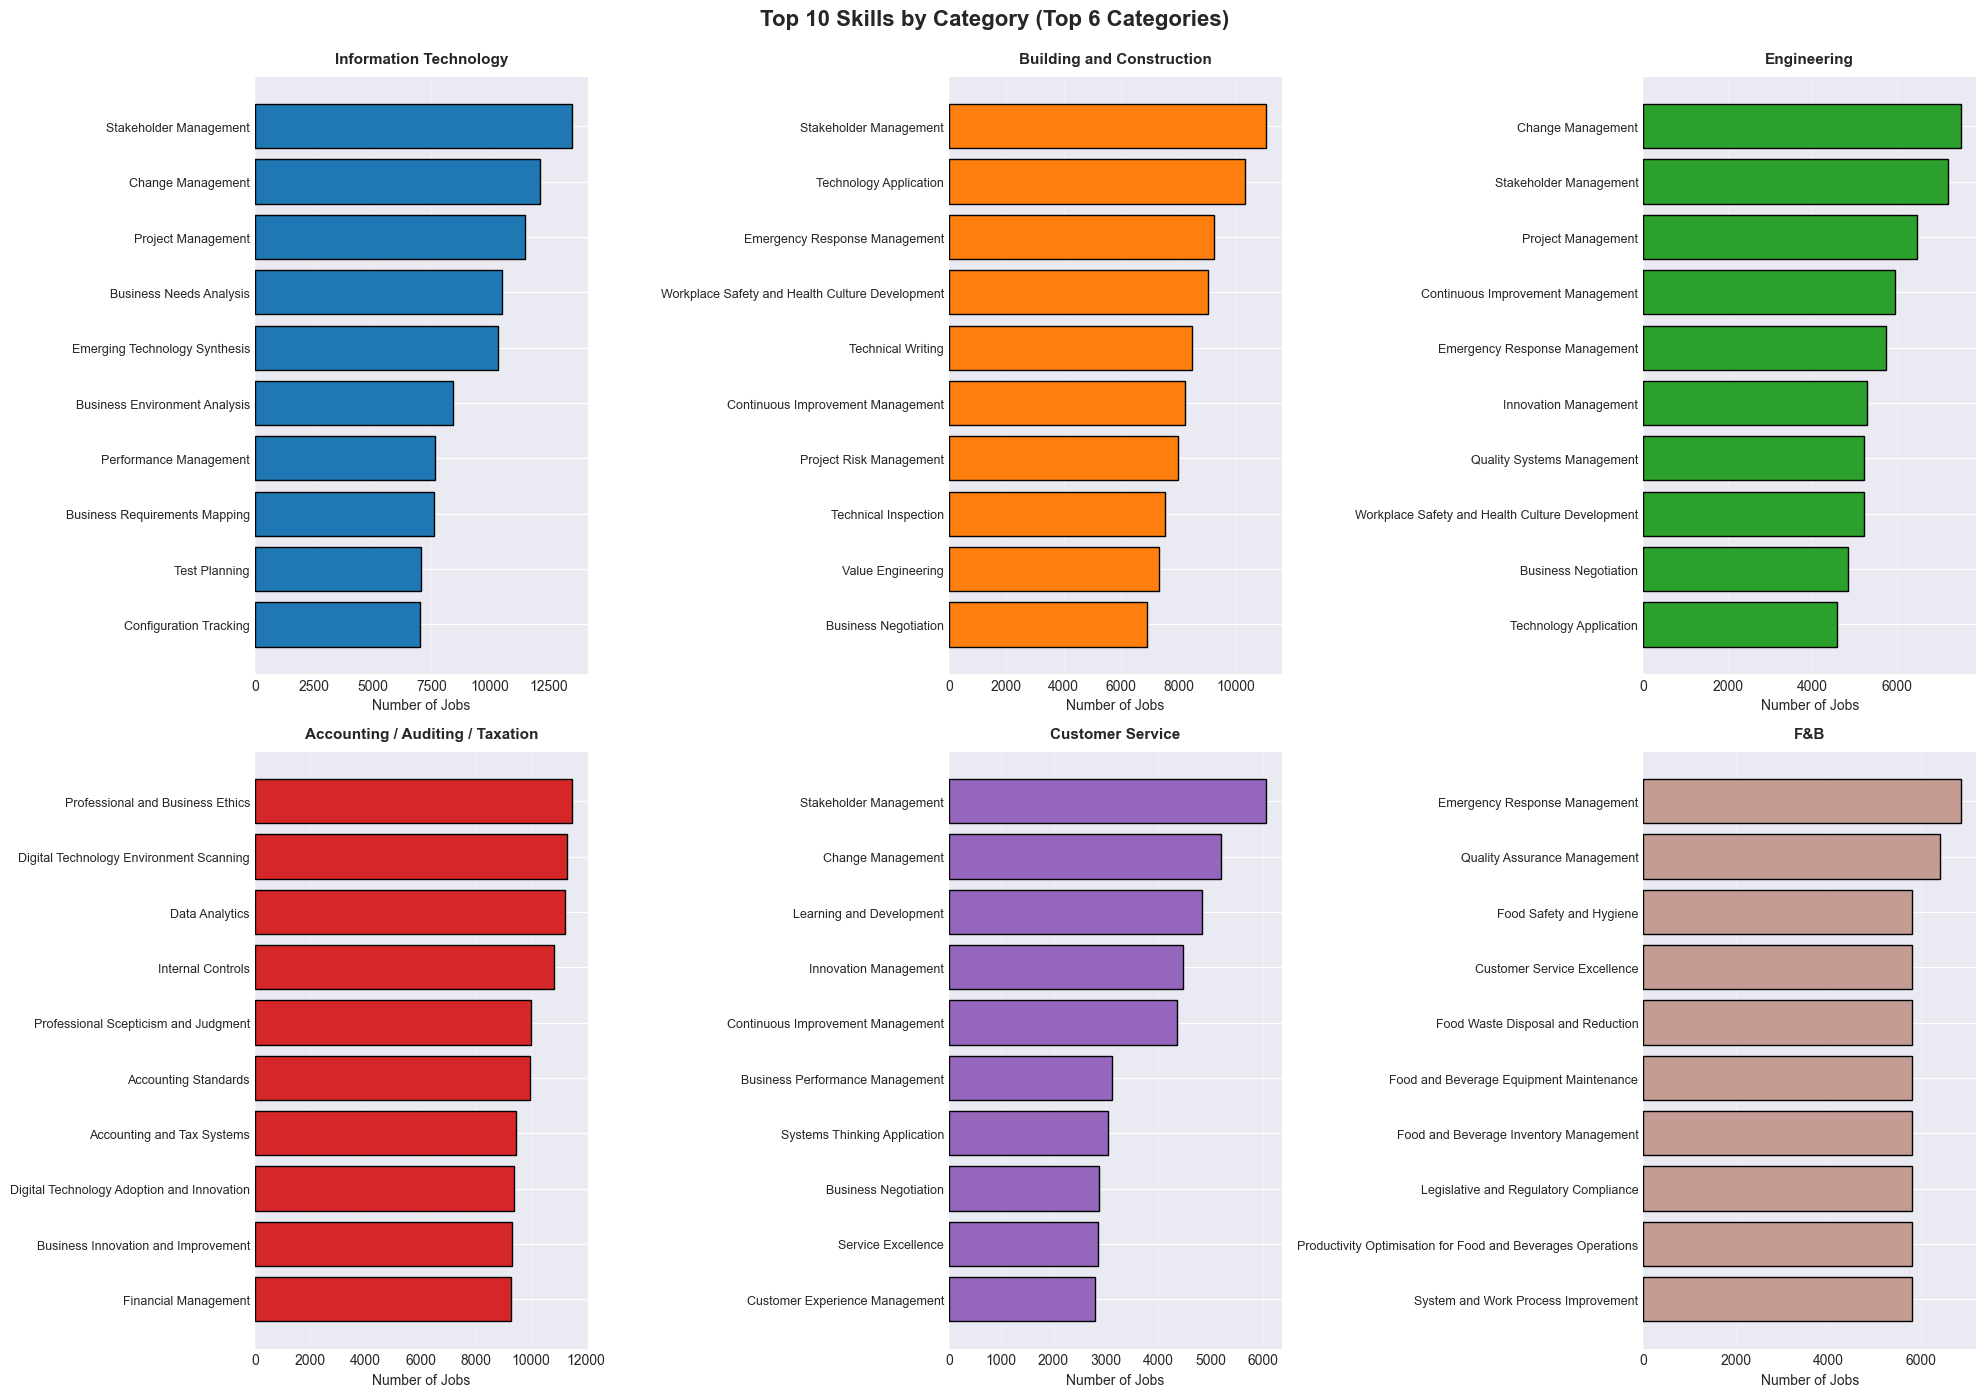

In [15]:
# Top 10 skills per category
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
axes = axes.flatten()

for idx, category in enumerate(top_categories):
    data = category_skills[category_skills['category'] == category].nlargest(10, 'job_count')
    
    colors = plt.cm.tab20(np.linspace(0, 1, 10))
    axes[idx].barh(range(len(data)), data['job_count'], color=colors[idx], edgecolor='black')
    axes[idx].set_yticks(range(len(data)))
    axes[idx].set_yticklabels(data['skill'], fontsize=9)
    axes[idx].set_title(f'{category}', fontsize=11, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Number of Jobs', fontsize=10)
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.suptitle('Top 10 Skills by Category (Top 6 Categories)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

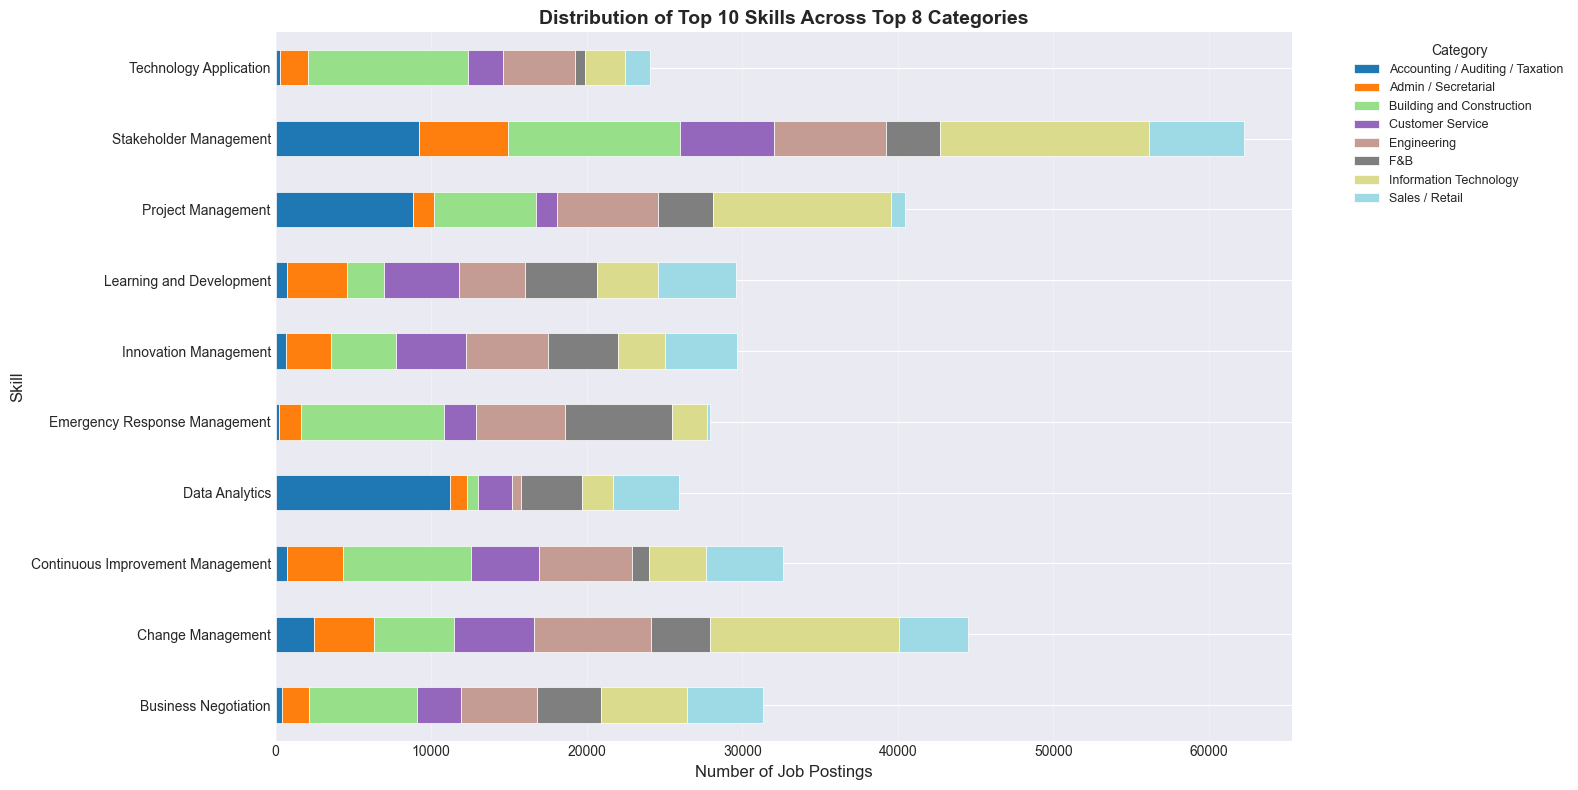

In [16]:
# Stacked bar: Top 10 skills distribution across top 8 categories
top_10_skills = skill_counts.head(10).index
top_8_categories = df.groupby('category_name')['job_id'].nunique().nlargest(8).index

skill_category_matrix = df[(df['skill'].isin(top_10_skills)) & 
                           (df['category_name'].isin(top_8_categories))].groupby(['skill', 'category_name'])['job_id'].nunique().reset_index()

pivot_data = skill_category_matrix.pivot_table(
    index='skill', 
    columns='category_name', 
    values='job_id', 
    fill_value=0
)

ax = pivot_data.plot(kind='barh', stacked=True, figsize=(16, 8), 
                     colormap='tab20', edgecolor='white', linewidth=0.5)
plt.xlabel('Number of Job Postings', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.title('Distribution of Top 10 Skills Across Top 8 Categories', fontsize=14, fontweight='bold')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Universal Skills (Cross-Category Analysis)

In [17]:
# Calculate how many categories each skill appears in
skill_category_coverage = df.groupby('skill').agg({
    'category_name': 'nunique',
    'job_id': 'nunique'
}).reset_index()
skill_category_coverage.columns = ['skill', 'num_categories', 'total_jobs']

# Universal skills (appear in many categories)
universal_skills = skill_category_coverage.sort_values('num_categories', ascending=False)

print(f"Total categories available: {df['category_name'].nunique()}")
print(f"\nTop 10 most universal skills:")
for i, (idx, row) in enumerate(universal_skills.head(10).iterrows(), 1):
    print(f"{i}. {row['skill']}: {row['num_categories']} categories, {row['total_jobs']:,} jobs")

Total categories available: 43

Top 10 most universal skills:
1. Vendor Management: 43 categories, 35,512 jobs
2. Risk Management and Administration: 43 categories, 16,301 jobs
3. Contract Development and Management: 43 categories, 24,146 jobs
4. Effectiveness Management: 43 categories, 30,916 jobs
5. Continuous Quality Improvement: 43 categories, 12,215 jobs
6. Stakeholder Management: 43 categories, 98,229 jobs
7. Systems Thinking Application: 43 categories, 33,367 jobs
8. Operational Risk Management: 43 categories, 8,107 jobs
9. Technology Application: 43 categories, 38,935 jobs
10. Technology Integration: 43 categories, 30,744 jobs


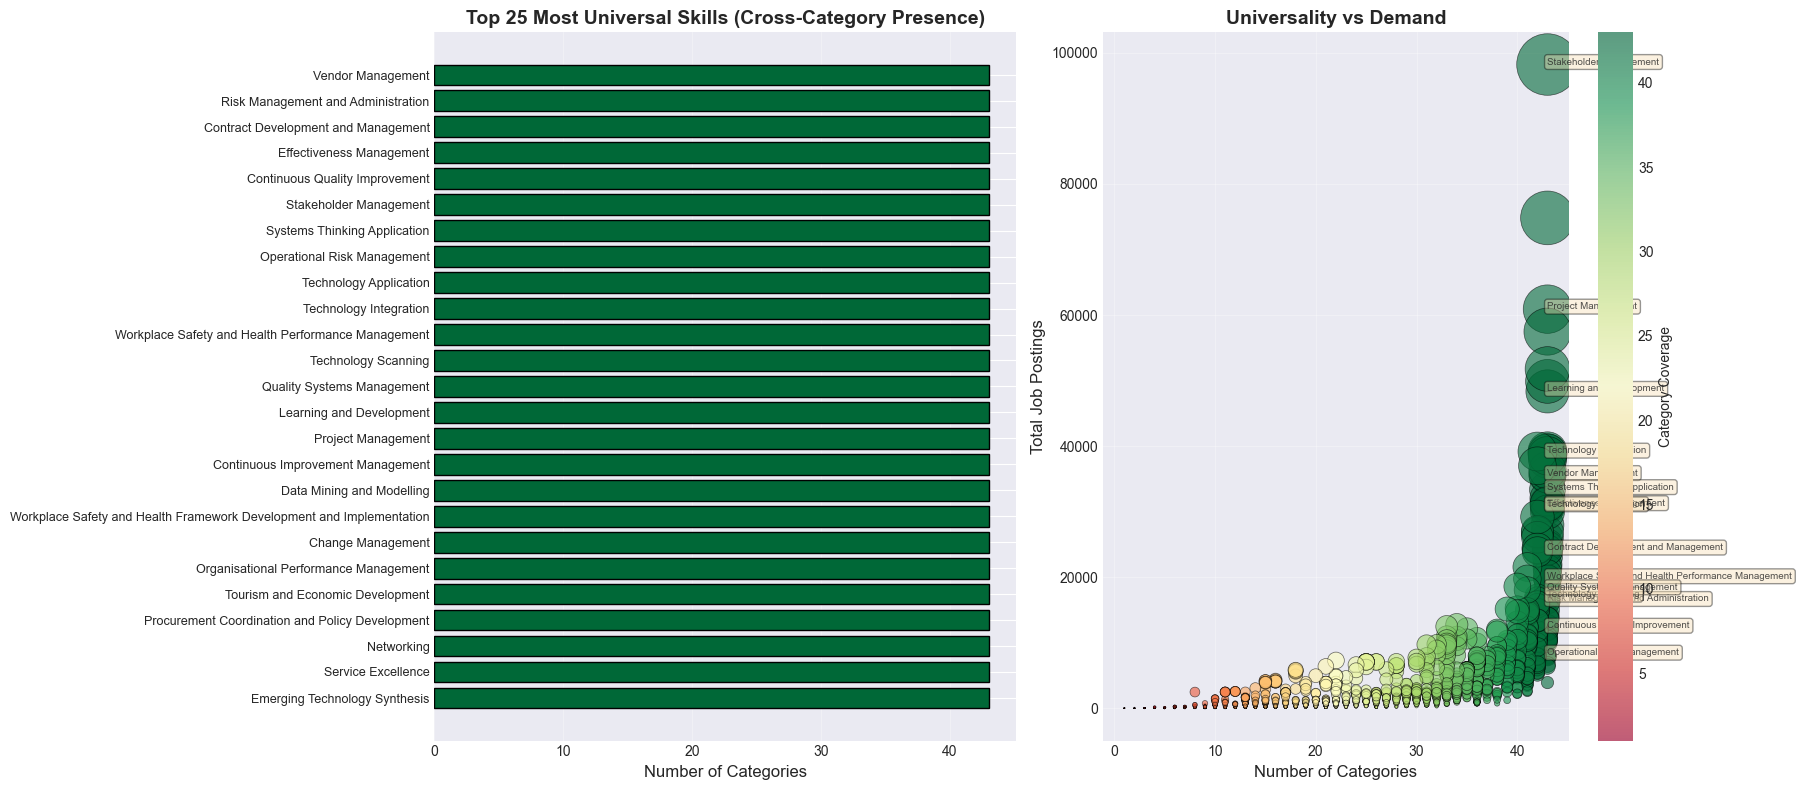

In [18]:
# Visualization: Universal skills
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Top 25 universal skills by category coverage
top_25_universal = universal_skills.head(25)
colors = plt.cm.RdYlGn(top_25_universal['num_categories'] / top_25_universal['num_categories'].max())
ax1.barh(range(len(top_25_universal)), top_25_universal['num_categories'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(top_25_universal)))
ax1.set_yticklabels(top_25_universal['skill'], fontsize=9)
ax1.set_xlabel('Number of Categories', fontsize=12)
ax1.set_title('Top 25 Most Universal Skills (Cross-Category Presence)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Scatter: Category coverage vs total demand
scatter = ax2.scatter(universal_skills['num_categories'], 
                     universal_skills['total_jobs'],
                     s=universal_skills['total_jobs']/50,
                     alpha=0.6,
                     c=universal_skills['num_categories'],
                     cmap='RdYlGn',
                     edgecolors='black',
                     linewidth=0.5)

# Annotate top universal skills
for idx, row in top_25_universal.head(15).iterrows():
    ax2.annotate(row['skill'], 
                xy=(row['num_categories'], row['total_jobs']),
                fontsize=7, alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.4))

ax2.set_xlabel('Number of Categories', fontsize=12)
ax2.set_ylabel('Total Job Postings', fontsize=12)
ax2.set_title('Universality vs Demand', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Category Coverage')

plt.tight_layout()
plt.show()

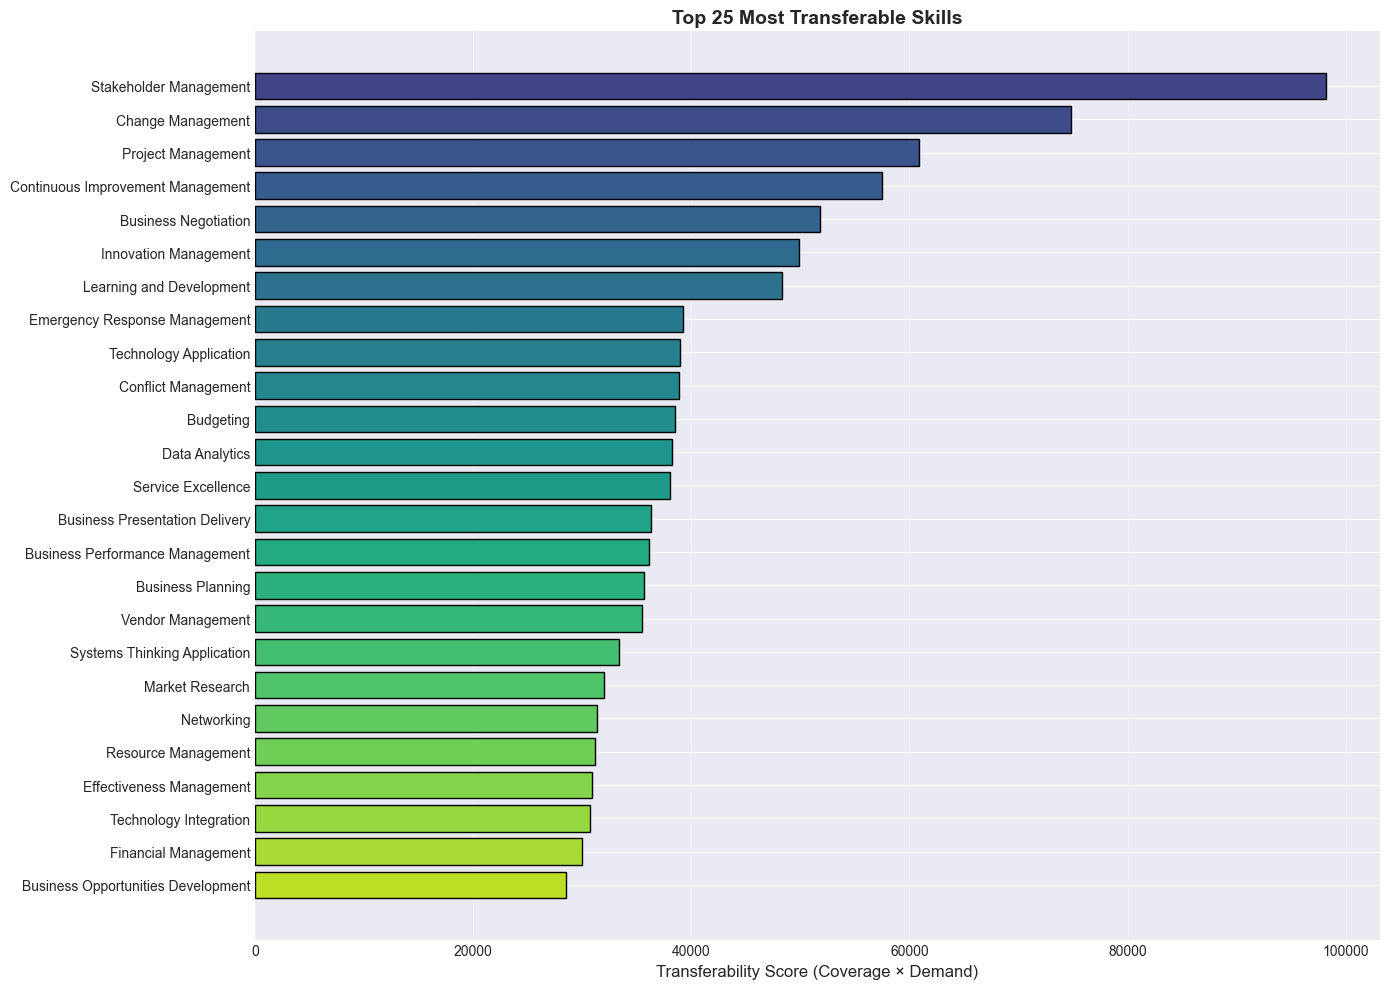


Transferability Score = (Number of Categories / Total Categories) × Total Job Demand
This metric identifies skills that are both widespread across industries AND in high demand.


In [19]:
# Transferability score: (num_categories / max_categories) * total_jobs
max_categories = df['category_name'].nunique()
universal_skills['transferability_score'] = (universal_skills['num_categories'] / max_categories) * universal_skills['total_jobs']
top_transferable = universal_skills.nlargest(25, 'transferability_score')

plt.figure(figsize=(14, 10))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(top_transferable)))
bars = plt.barh(range(len(top_transferable)), top_transferable['transferability_score'], 
                color=colors, edgecolor='black')
plt.yticks(range(len(top_transferable)), top_transferable['skill'], fontsize=10)
plt.xlabel('Transferability Score (Coverage × Demand)', fontsize=12)
plt.title('Top 25 Most Transferable Skills', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTransferability Score = (Number of Categories / Total Categories) × Total Job Demand")
print("This metric identifies skills that are both widespread across industries AND in high demand.")

## 7. Skill Co-occurrence Network

In [20]:
# Which skills frequently appear together in job postings?
# Group skills by job_id
job_skills = df.groupby('job_id')['skill'].apply(list).reset_index()

# For performance, limit to top 40 skills
top_40_skills = skill_counts.head(40).index
skill_pairs = []

print("Calculating skill co-occurrences...")
for skills_list in job_skills['skill']:
    # Filter to top skills
    filtered_skills = [s for s in skills_list if s in top_40_skills]
    if len(filtered_skills) > 1:
        # Get all pairs of skills in this job
        skill_pairs.extend(combinations(sorted(filtered_skills), 2))

# Count pairs
pair_counts = Counter(skill_pairs)
top_pairs = dict(pair_counts.most_common(150))

print(f"Total skill pairs found: {len(pair_counts):,}")
print(f"Top 10 most common skill pairs:")
for (skill1, skill2), count in list(top_pairs.items())[:10]:
    print(f"  {skill1} <-> {skill2}: {count:,} jobs")

Calculating skill co-occurrences...
Total skill pairs found: 801
Top 10 most common skill pairs:
  Business Negotiation <-> Stakeholder Management: 213,437 jobs
  Market Research <-> Stakeholder Management: 201,329 jobs
  Change Management <-> Stakeholder Management: 161,356 jobs
  Business Negotiation <-> Market Research: 153,911 jobs
  Customer Experience Management <-> Stakeholder Management: 133,865 jobs
  Customer Experience Management <-> Market Research: 129,013 jobs
  Business Negotiation <-> Networking: 127,679 jobs
  Budgeting <-> Stakeholder Management: 126,236 jobs
  Learning and Development <-> Stakeholder Management: 125,843 jobs
  Data Analytics <-> Stakeholder Management: 121,086 jobs


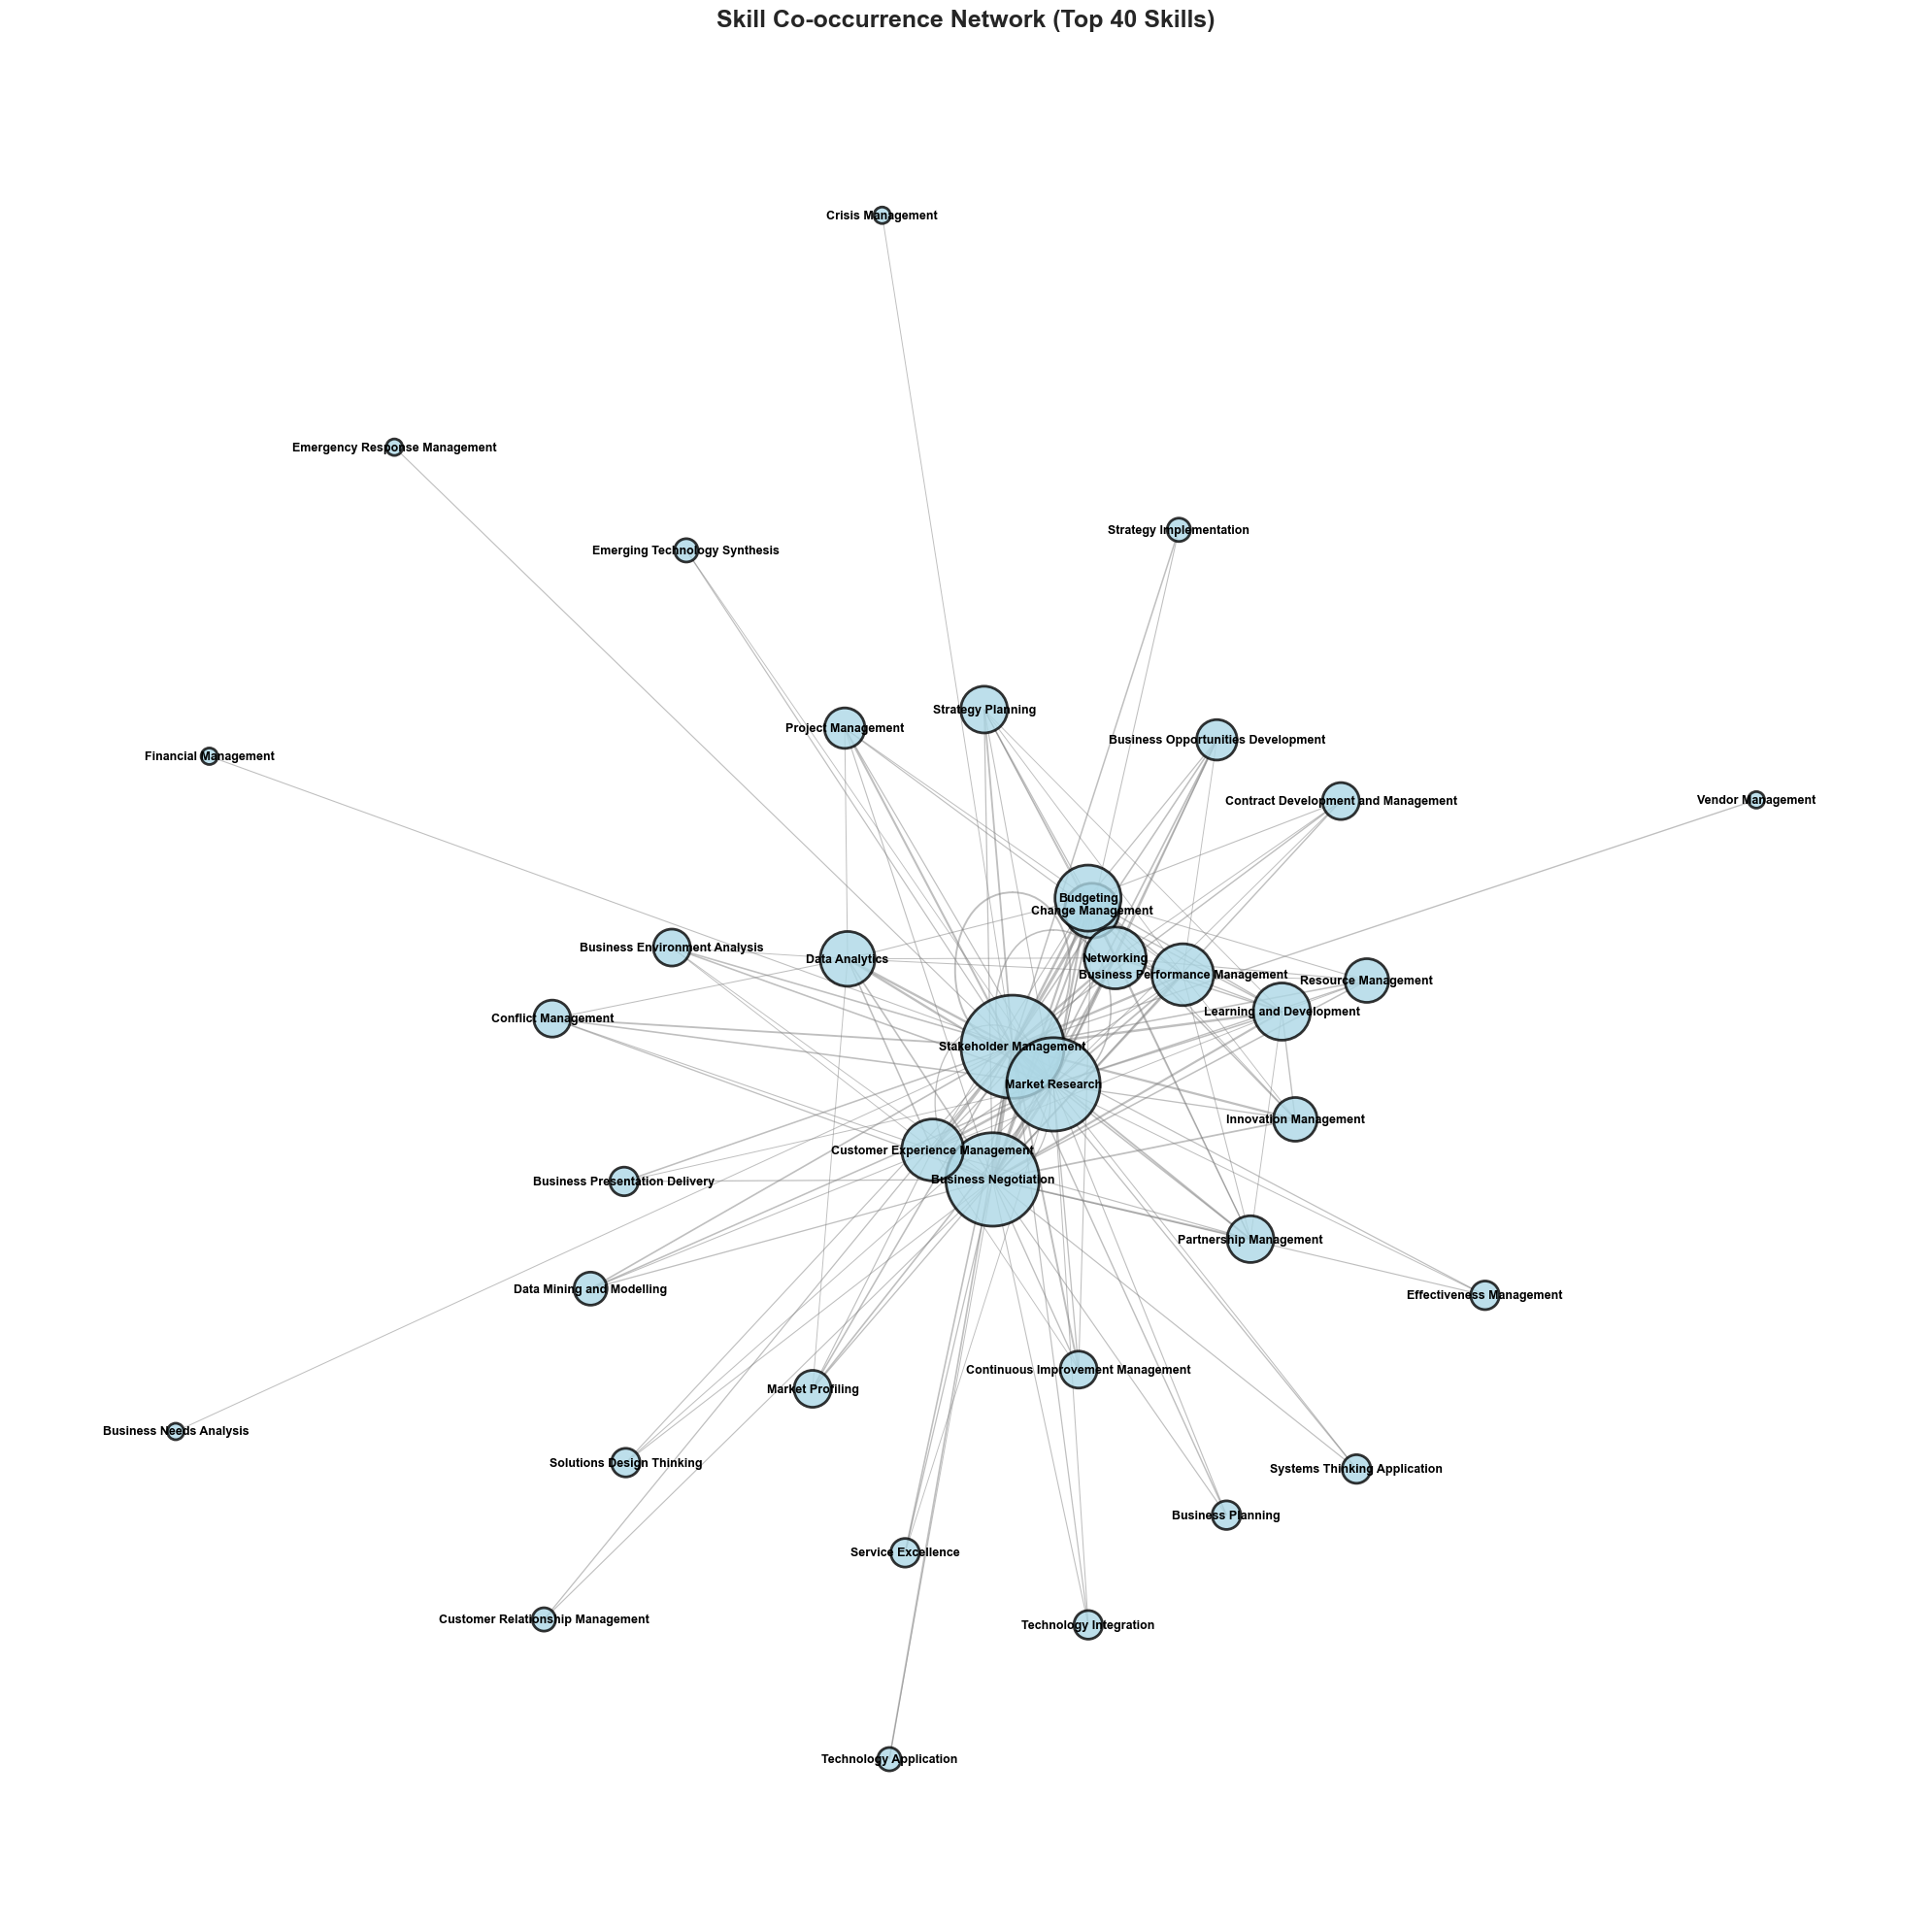


Network Statistics:
Nodes (Skills): 38
Edges (Co-occurrences): 150

Top 10 Most Connected Skills (by degree):
  Stakeholder Management: 39 connections
  Business Negotiation: 32 connections
  Market Research: 32 connections
  Budgeting: 16 connections
  Customer Experience Management: 14 connections
  Networking: 14 connections
  Business Performance Management: 14 connections
  Learning and Development: 12 connections
  Change Management: 11 connections
  Data Analytics: 11 connections


In [21]:
# Create network graph
try:
    import networkx as nx
    
    G = nx.Graph()
    for (skill1, skill2), count in top_pairs.items():
        G.add_edge(skill1, skill2, weight=count)
    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.8, iterations=50, seed=42)
    
    # Node sizes by degree (connectivity)
    node_sizes = [G.degree(node) * 150 for node in G.nodes()]
    
    # Edge widths by weight
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_weight = max(weights)
    edge_widths = [3 * w / max_weight for w in weights]
    
    # Draw network
    nx.draw_networkx_nodes(G, pos, 
                          node_size=node_sizes,
                          node_color='lightblue',
                          edgecolors='black',
                          linewidths=2,
                          alpha=0.8)
    
    nx.draw_networkx_edges(G, pos,
                          width=edge_widths,
                          edge_color='gray',
                          alpha=0.5)
    
    nx.draw_networkx_labels(G, pos,
                           font_size=9,
                           font_weight='bold',
                           font_color='black')
    
    plt.title('Skill Co-occurrence Network (Top 40 Skills)', fontsize=18, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Network statistics
    print(f"\nNetwork Statistics:")
    print(f"Nodes (Skills): {G.number_of_nodes()}")
    print(f"Edges (Co-occurrences): {G.number_of_edges()}")
    print(f"\nTop 10 Most Connected Skills (by degree):")
    degree_dict = dict(G.degree())
    sorted_degrees = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
    for skill, degree in sorted_degrees[:10]:
        print(f"  {skill}: {degree} connections")
        
except ImportError:
    print("NetworkX not installed. Skipping network visualization.")
    print("Install with: pip install networkx")

## 8. Comprehensive Dashboard Summary

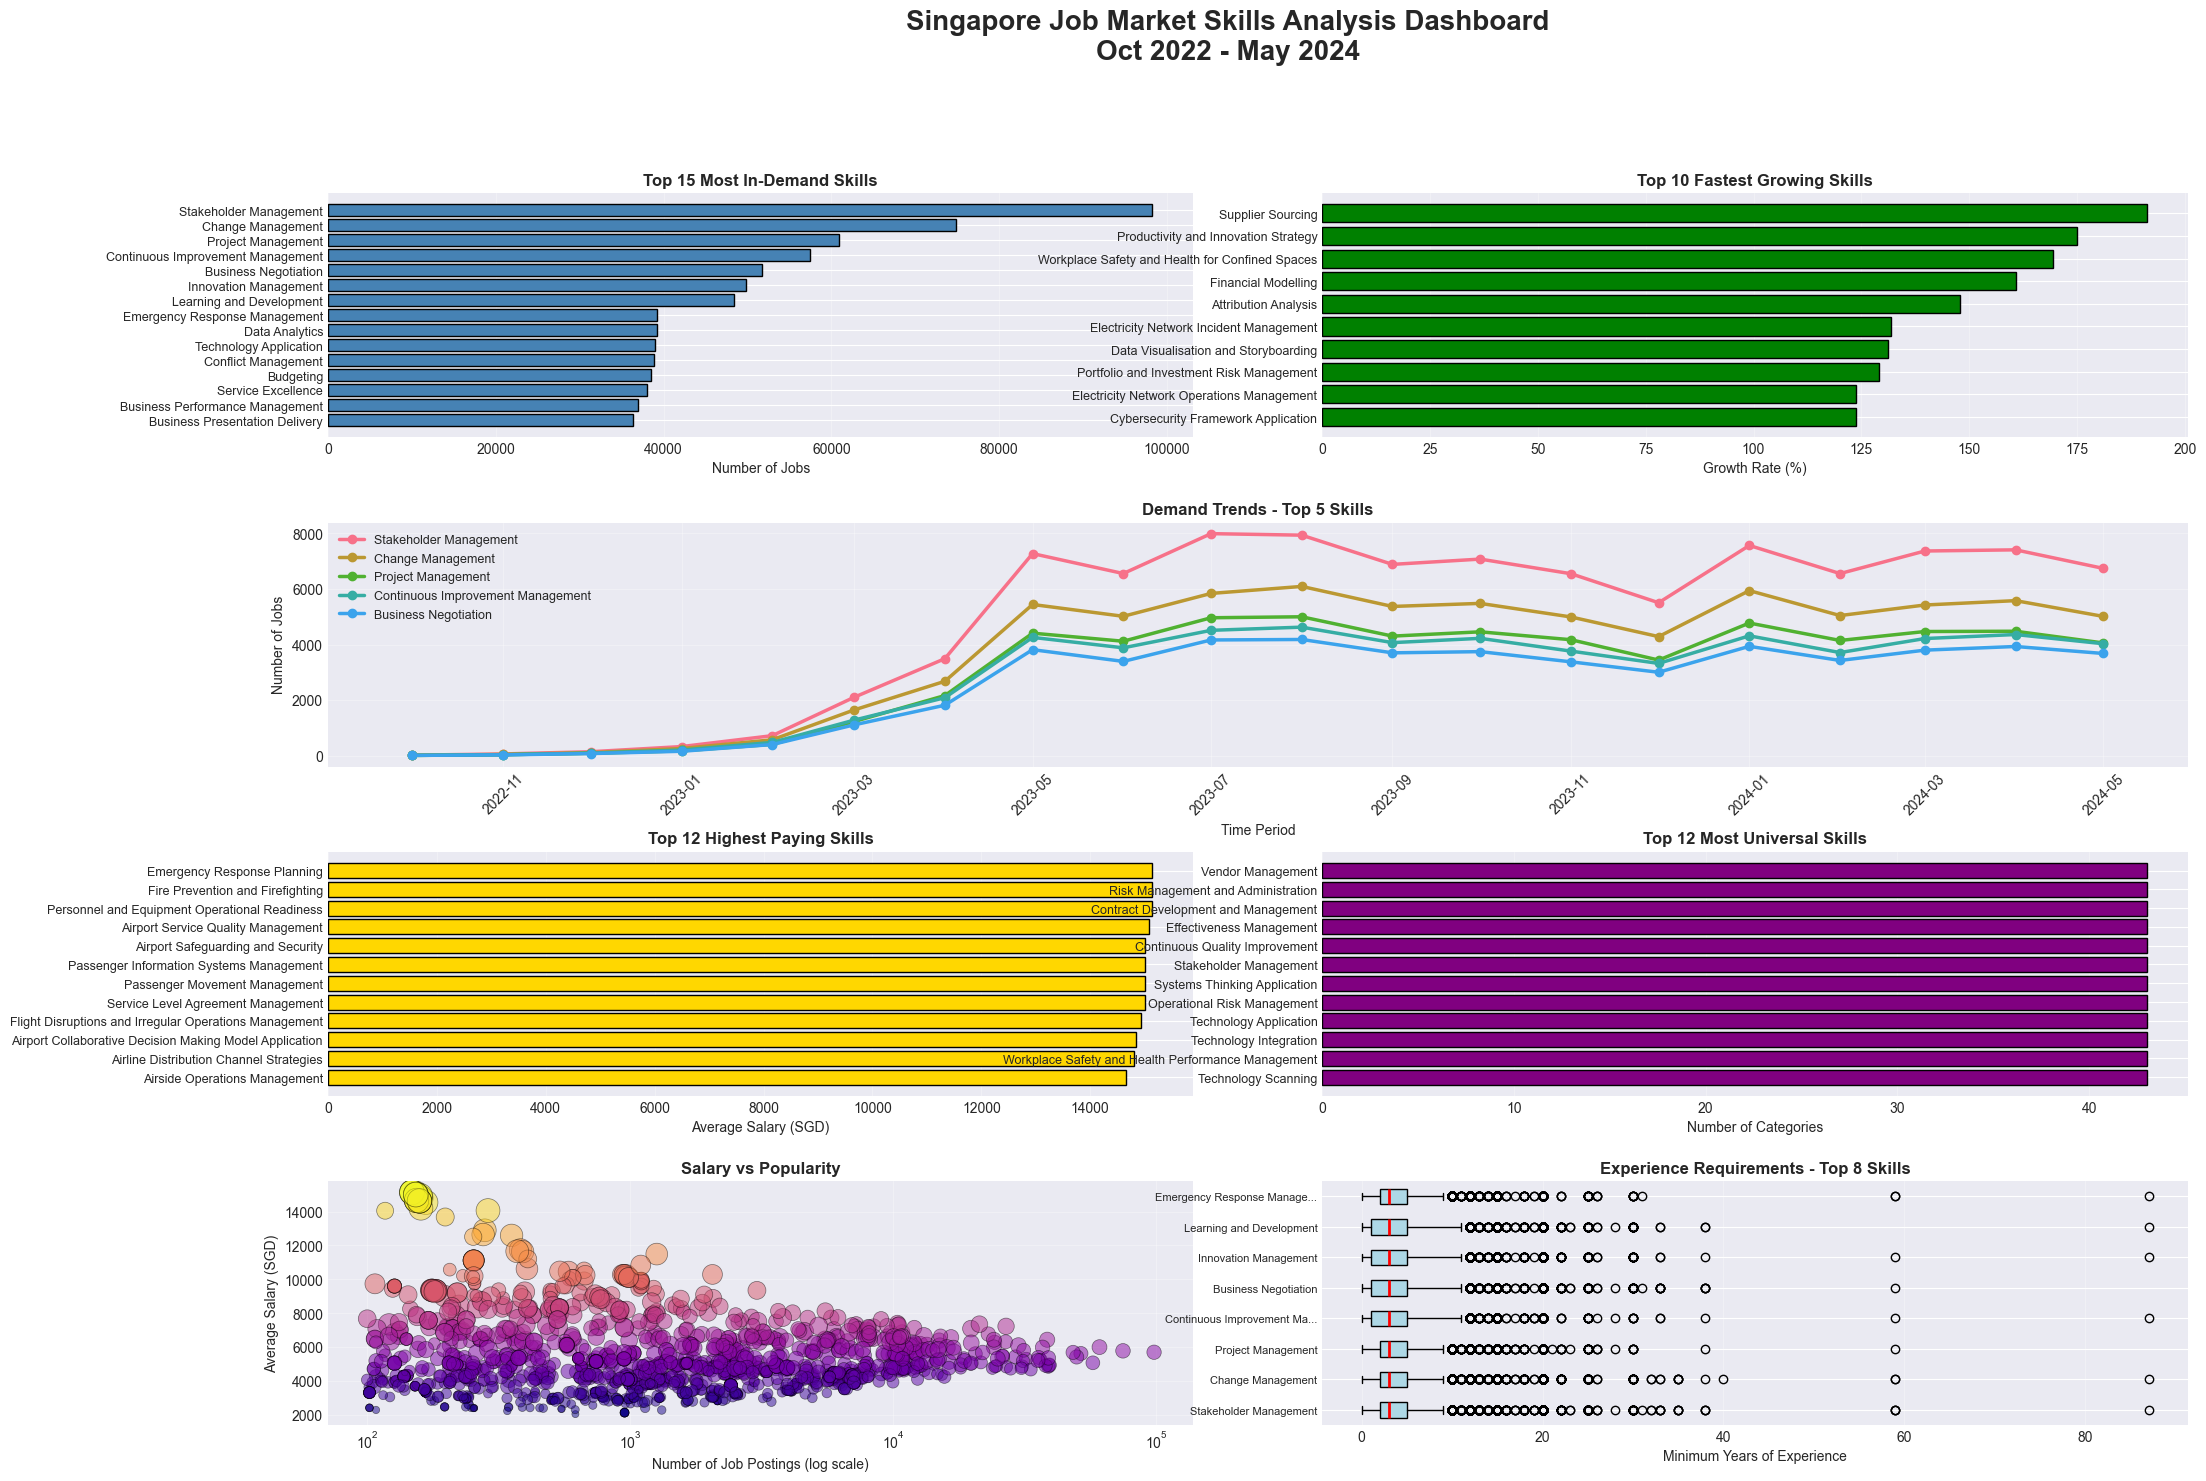

In [22]:
# Create comprehensive summary dashboard
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

# 1. Top 15 Skills
ax1 = fig.add_subplot(gs[0, :2])
top_15 = skill_counts.head(15)
ax1.barh(range(len(top_15)), top_15.values, color='steelblue', edgecolor='black')
ax1.set_yticks(range(len(top_15)))
ax1.set_yticklabels(top_15.index, fontsize=9)
ax1.set_title('Top 15 Most In-Demand Skills', fontweight='bold', fontsize=12)
ax1.set_xlabel('Number of Jobs')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Top 10 Emerging Skills
ax2 = fig.add_subplot(gs[0, 2:])
emerging_top10 = growth_rate_filtered.head(10)
ax2.barh(range(len(emerging_top10)), emerging_top10.values, color='green', edgecolor='black')
ax2.set_yticks(range(len(emerging_top10)))
ax2.set_yticklabels(emerging_top10.index, fontsize=9)
ax2.set_title('Top 10 Fastest Growing Skills', fontweight='bold', fontsize=12)
ax2.set_xlabel('Growth Rate (%)')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Skill Timeline (Top 5)
ax3 = fig.add_subplot(gs[1, :])
for skill in top_10_skills[:5]:
    data = skill_timeline[skill_timeline['skill'] == skill]
    ax3.plot(data['year_month_dt'], data['unique_jobs'], marker='o', label=skill, linewidth=2.5, markersize=6)
ax3.set_title('Demand Trends - Top 5 Skills', fontweight='bold', fontsize=12)
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Number of Jobs')
ax3.legend(loc='best', fontsize=9)
ax3.grid(alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Top Premium Skills
ax4 = fig.add_subplot(gs[2, :2])
premium_top12 = skill_salary_filtered.nlargest(12, 'avg_salary')
ax4.barh(range(len(premium_top12)), premium_top12['avg_salary'], color='gold', edgecolor='black')
ax4.set_yticks(range(len(premium_top12)))
ax4.set_yticklabels(premium_top12['skill'], fontsize=9)
ax4.set_title('Top 12 Highest Paying Skills', fontweight='bold', fontsize=12)
ax4.set_xlabel('Average Salary (SGD)')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# 5. Universal Skills
ax5 = fig.add_subplot(gs[2, 2:])
universal_top12 = universal_skills.head(12)
ax5.barh(range(len(universal_top12)), universal_top12['num_categories'], color='purple', edgecolor='black')
ax5.set_yticks(range(len(universal_top12)))
ax5.set_yticklabels(universal_top12['skill'], fontsize=9)
ax5.set_title('Top 12 Most Universal Skills', fontweight='bold', fontsize=12)
ax5.set_xlabel('Number of Categories')
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

# 6. Salary vs Popularity
ax6 = fig.add_subplot(gs[3, :2])
scatter = ax6.scatter(skill_salary_filtered['job_count'], 
                     skill_salary_filtered['avg_salary'],
                     s=skill_salary_filtered['avg_exp']*30,
                     alpha=0.5,
                     c=skill_salary_filtered['avg_salary'],
                     cmap='plasma',
                     edgecolors='black',
                     linewidth=0.5)
ax6.set_xlabel('Number of Job Postings (log scale)')
ax6.set_ylabel('Average Salary (SGD)')
ax6.set_title('Salary vs Popularity', fontweight='bold', fontsize=12)
ax6.set_xscale('log')
ax6.grid(alpha=0.3)

# 7. Experience Distribution (Top 8 Skills)
ax7 = fig.add_subplot(gs[3, 2:])
top_8_skills = skill_counts.head(8).index
exp_data = [df[df['skill'] == skill]['min_exp'].dropna().values for skill in top_8_skills]
bp = ax7.boxplot(exp_data, labels=[s[:25] + '...' if len(s) > 25 else s for s in top_8_skills], 
                 vert=False, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', edgecolor='black'),
                 medianprops=dict(color='red', linewidth=2))
ax7.set_xlabel('Minimum Years of Experience')
ax7.set_title('Experience Requirements - Top 8 Skills', fontweight='bold', fontsize=12)
ax7.grid(axis='x', alpha=0.3)
ax7.tick_params(axis='y', labelsize=8)

fig.suptitle('Singapore Job Market Skills Analysis Dashboard\nOct 2022 - May 2024', 
             fontsize=20, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

## Key Insights Summary

In [23]:
# Generate key insights
print("=" * 80)
print("KEY INSIGHTS FROM SKILLS ANALYSIS")
print("=" * 80)

print("\n1. MARKET OVERVIEW")
print(f"   • Total unique skills: {df['skill'].nunique():,}")
print(f"   • Total job postings analyzed: {df['job_id'].nunique():,}")
print(f"   • Analysis period: {df['posting_date'].min().date()} to {df['posting_date'].max().date()}")
print(f"   • Top skill: {skill_counts.index[0]} ({skill_counts.iloc[0]:,} jobs)")

print("\n2. EMERGING SKILLS (Fastest Growing)")
for i, (skill, rate) in enumerate(growth_rate_filtered.head(5).items(), 1):
    print(f"   {i}. {skill}: +{rate:.1f}%")

print("\n3. DECLINING SKILLS (Fastest Declining)")
for i, (skill, rate) in enumerate(growth_rate_filtered.tail(5).items(), 1):
    print(f"   {i}. {skill}: {rate:.1f}%")

print("\n4. HIGHEST PAYING SKILLS")
for i, (idx, row) in enumerate(skill_salary_filtered.nlargest(5, 'avg_salary').iterrows(), 1):
    print(f"   {i}. {row['skill']}: ${row['avg_salary']:.0f} (avg exp: {row['avg_exp']:.1f} yrs)")

print("\n5. MOST UNIVERSAL SKILLS (Cross-Industry)")
for i, (idx, row) in enumerate(universal_skills.head(5).iterrows(), 1):
    print(f"   {i}. {row['skill']}: {row['num_categories']} categories, {row['total_jobs']:,} jobs")

print("\n6. HIGH-VALUE SKILLS (High Salary + Low Experience Barrier)")
for i, (idx, row) in enumerate(high_value_skills.head(5).iterrows(), 1):
    print(f"   {i}. {row['skill']}: ${row['avg_salary']:.0f} salary, {row['avg_exp']:.1f} yrs exp")

print("\n7. CONCENTRATION INSIGHTS")
top_10_pct = cumulative_pct.iloc[9]
top_100_pct = cumulative_pct.iloc[99]
print(f"   • Top 10 skills account for {top_10_pct:.1f}% of total demand")
print(f"   • Top 100 skills account for {top_100_pct:.1f}% of total demand")
print(f"   • {skills_for_80pct} skills account for 80% of total demand")

print("\n" + "=" * 80)

KEY INSIGHTS FROM SKILLS ANALYSIS

1. MARKET OVERVIEW
   • Total unique skills: 2,053
   • Total job postings analyzed: 154,490
   • Analysis period: 2022-10-06 to 2024-05-29
   • Top skill: Stakeholder Management (98,229 jobs)

2. EMERGING SKILLS (Fastest Growing)
   1. Supplier Sourcing: +191.2%
   2. Productivity and Innovation Strategy: +175.0%
   3. Workplace Safety and Health for Confined Spaces: +169.6%
   4. Financial Modelling: +160.9%
   5. Attribution Analysis: +147.8%

3. DECLINING SKILLS (Fastest Declining)
   1. Room Reservation Operations Management: -27.8%
   2. Security Strategy: -30.4%
   3. Cargo Load Planning: -40.5%
   4. Performance Management for Nursing: -48.1%
   5. Strategy Management: -48.1%

4. HIGHEST PAYING SKILLS
   1. Emergency Response Planning: $15138 (avg exp: 10.6 yrs)
   2. Fire Prevention and Firefighting: $15138 (avg exp: 10.6 yrs)
   3. Personnel and Equipment Operational Readiness: $15138 (avg exp: 10.6 yrs)
   4. Airport Service Quality Managem